Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 4 - Exploring Financial Time Series Data

## 4.1 Outlier detection using rolling statistics

### How to do it...

1. Import the libraries:

In [22]:
import pandas as pd 
import yfinance as yf

2. Download Tesla's stock prices from 2019-2020 and calculate simple returns:

In [23]:
df = yf.download("TSLA", 
                 start="2019-01-01", 
                 end="2020-12-31",
                 progress=False)

df["rtn"] = df["Adj Close"].pct_change()
df = df[["rtn"]].copy()
df.head()


,rtn
Date,
2019-01-02,NaN
2019-01-03,-0.031472
2019-01-04,0.057697
2019-01-07,0.054361
2019-01-08,0.001164


3. Calculate the rolling mean and standard deviation:

In [24]:
df_rolling = df[["rtn"]].rolling(window=21) \
                        .agg(["mean", "std"])
df_rolling.columns = df_rolling.columns.droplevel()

df_rolling

,mean,std
Date,,
2019-01-02,NaN,NaN
2019-01-03,NaN,NaN
2019-01-04,NaN,NaN
2019-01-07,NaN,NaN
2019-01-08,NaN,NaN
...,...,...
2020-12-23,0.011014,0.041006
2020-12-24,0.009119,0.039307
2020-12-28,0.007660,0.038922


4. Join the rolling data back to the initial DataFrame:

In [25]:
df = df.join(df_rolling)
df.tail()

,rtn,mean,std
Date,,,
2020-12-23,0.008808,0.011014,0.041006
2020-12-24,0.024443,0.009119,0.039307
2020-12-28,0.002901,0.007660,0.038922
2020-12-29,0.003466,0.006850,0.038819
2020-12-30,0.043229,0.010384,0.038578


5. Calculate the upper and lower thresholds:

In [26]:
N_SIGMAS = 3
df["upper"] = df["mean"] + N_SIGMAS * df["std"]
df["lower"] = df["mean"] - N_SIGMAS * df["std"]

6. Identify the outliers using the previously calculated thresholds:

In [27]:
df["outlier"] = (
    (df["rtn"] > df["upper"]) | (df["rtn"] < df["lower"])
)

7. Plot the returns together with the thresholds and mark the outliers:

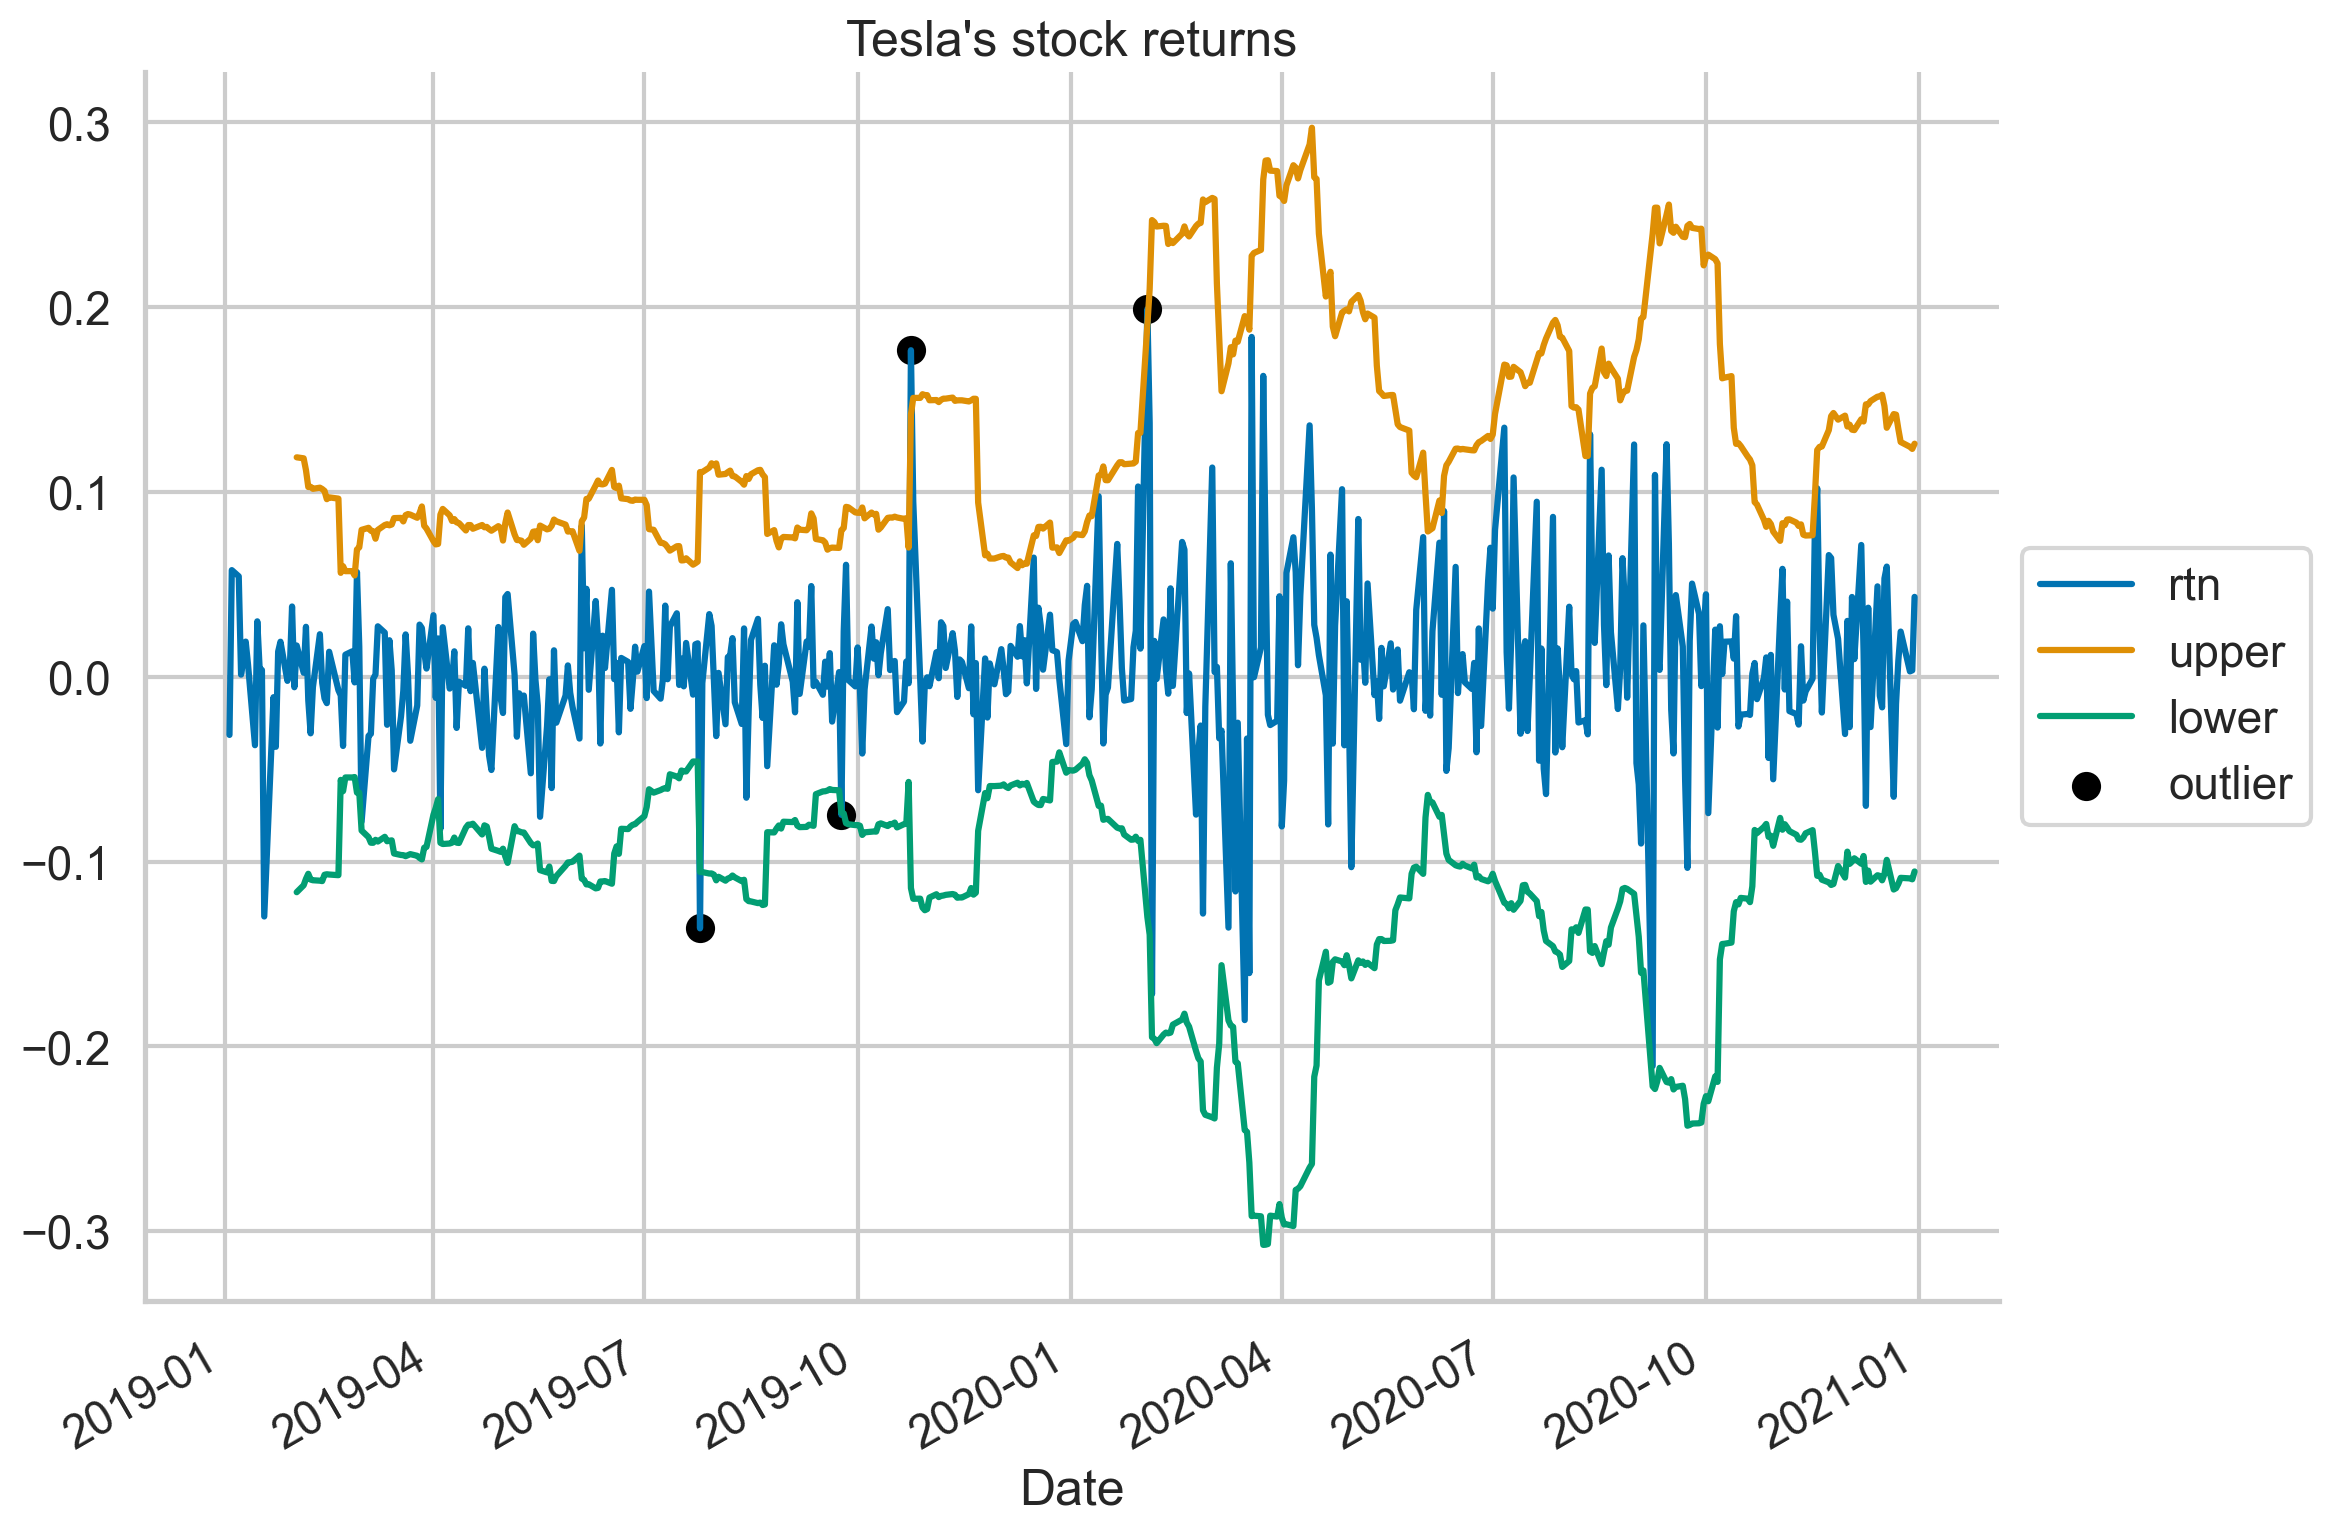

In [28]:
fig, ax = plt.subplots()

df[["rtn", "upper", "lower"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index, 
           df.loc[df["outlier"], "rtn"], 
           color="black", label="outlier")
ax.set_title("Tesla's stock returns")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_1", dpi=200)

### There's more

Define a function for identify outliers using the steps described in the previous section.

In [29]:
def identify_outliers(df, column, window_size, n_sigmas):
    """Function for identifying outliers using rolling statistics"""
    
    df = df[[column]].copy()
    df_rolling = df.rolling(window=window_size) \
                   .agg(["mean", "std"])
    df_rolling.columns = df_rolling.columns.droplevel()
    df = df.join(df_rolling)
    df["upper"] = df["mean"] + n_sigmas * df["std"]
    df["lower"] = df["mean"] - n_sigmas * df["std"]
    
    return ((df[column] > df["upper"]) | (df[column] < df["lower"]))
    

In [30]:
identify_outliers(df, "rtn", 21, 3)

Date
2019-01-02    False
2019-01-03    False
2019-01-04    False
2019-01-07    False
2019-01-08    False
              ...  
2020-12-23    False
2020-12-24    False
2020-12-28    False
2020-12-29    False
2020-12-30    False
Length: 504, dtype: bool

## 4.2 Outlier detection with the Hampel filter

### How to do it...

1. Import the libraries:

In [31]:
import yfinance as yf
from sktime.transformations.series.outlier_detection import HampelFilter

2. Download Tesla's stock prices from 2019-2020 and calculate simple returns:

In [32]:
df = yf.download("TSLA", 
                 start="2019-01-01", 
                 end="2020-12-31",
                 progress=False)
df["rtn"] = df["Adj Close"].pct_change()

3. Instantiate the `HampelFilter` class and use it for detecting the outliers:

In [33]:
hampel_detector = HampelFilter(window_length=10, 
                               return_bool=True)
df["outlier"] = hampel_detector.fit_transform(df["Adj Close"])
df.head()

,Open,High,Low,Close,Adj Close,Volume,rtn,outlier
Date,,,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000,NaN,False
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000,-0.031472,False
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500,0.057697,False
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000,0.054361,False
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500,0.001164,False


4. Plot Tesla's stock price and mark the outliers:

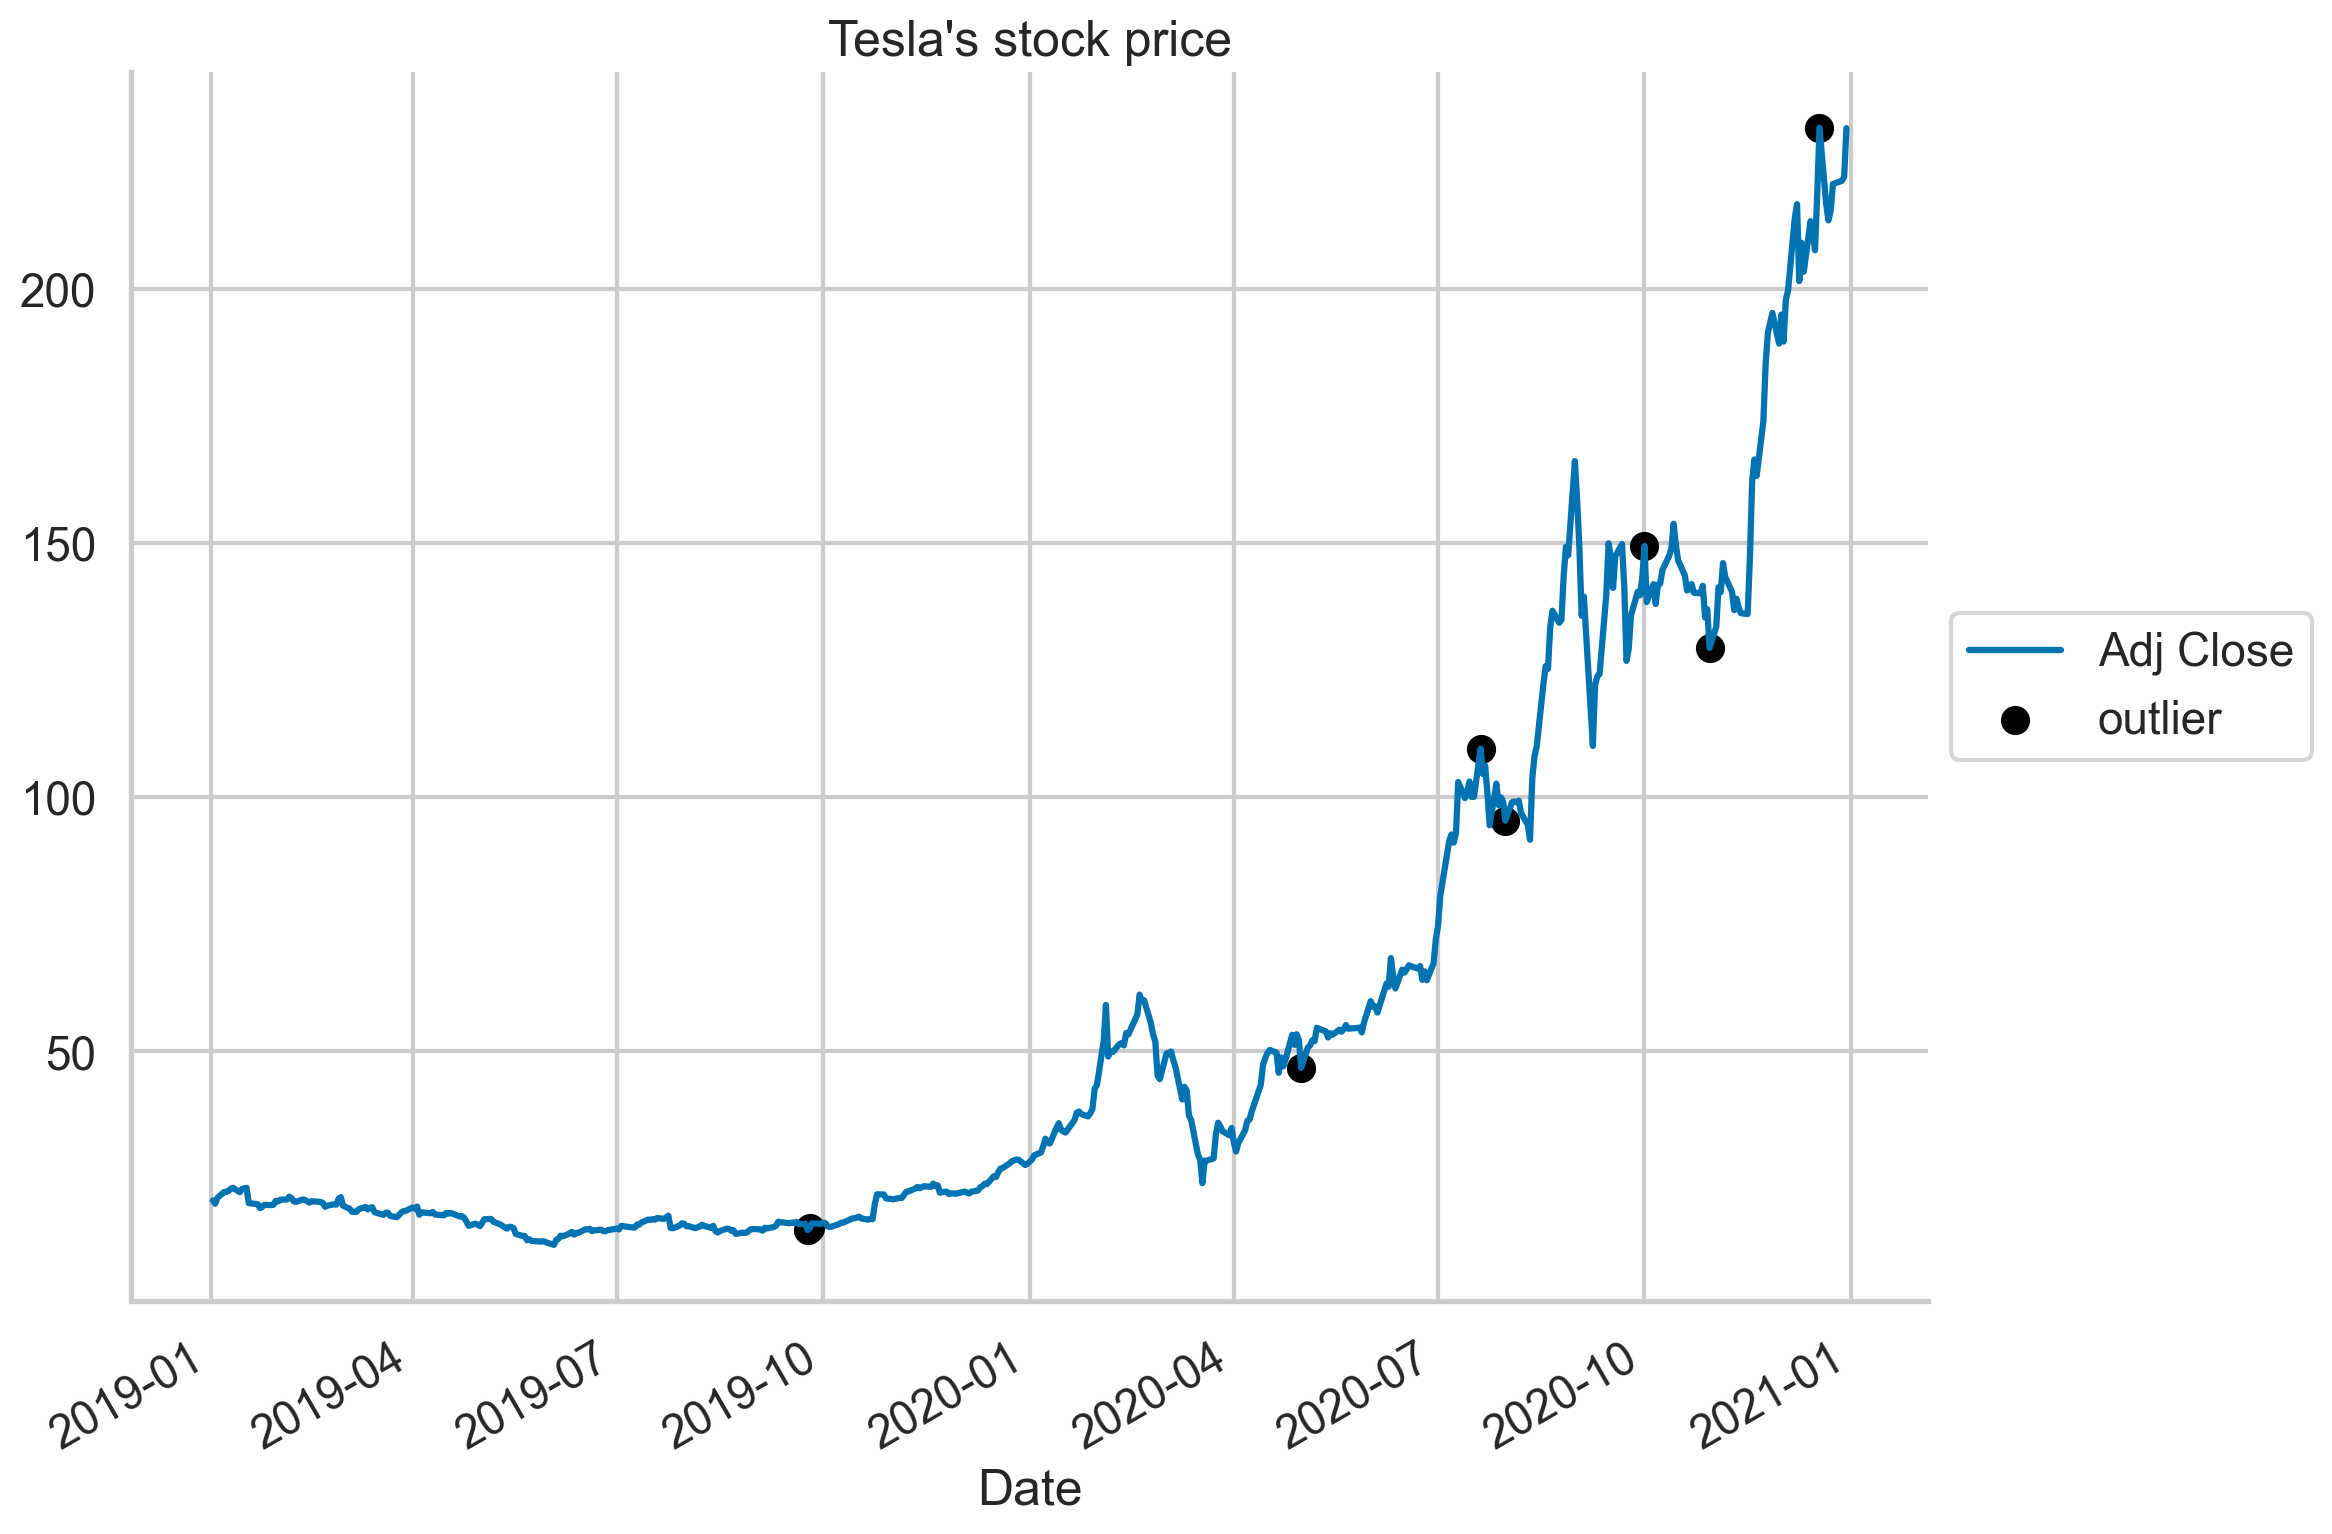

In [34]:
fig, ax = plt.subplots()

df[["Adj Close"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index, 
           df.loc[df["outlier"], "Adj Close"], 
           color="black", label="outlier")
ax.set_title("Tesla's stock price")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_2", dpi=200)

### There's more

1. Identify the outliers among the stock returns:

In [35]:
df["outlier_rtn"] = hampel_detector.fit_transform(df["rtn"])
df.head()

/Users/encore/miniconda3/envs/zj38/lib/python3.8/site-packages/sktime/transformations/series/outlier_detection.py:103: UserWarning: Series contains nan values, more nan might be
                added if there are outliers
  Z = self._transform_series(Z)


,Open,High,Low,Close,Adj Close,Volume,rtn,outlier,outlier_rtn
Date,,,,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000,NaN,False,True
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000,-0.031472,False,False
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500,0.057697,False,False
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000,0.054361,False,False
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500,0.001164,False,False


2. Plot Tesla's daily returns and mark the outliers:

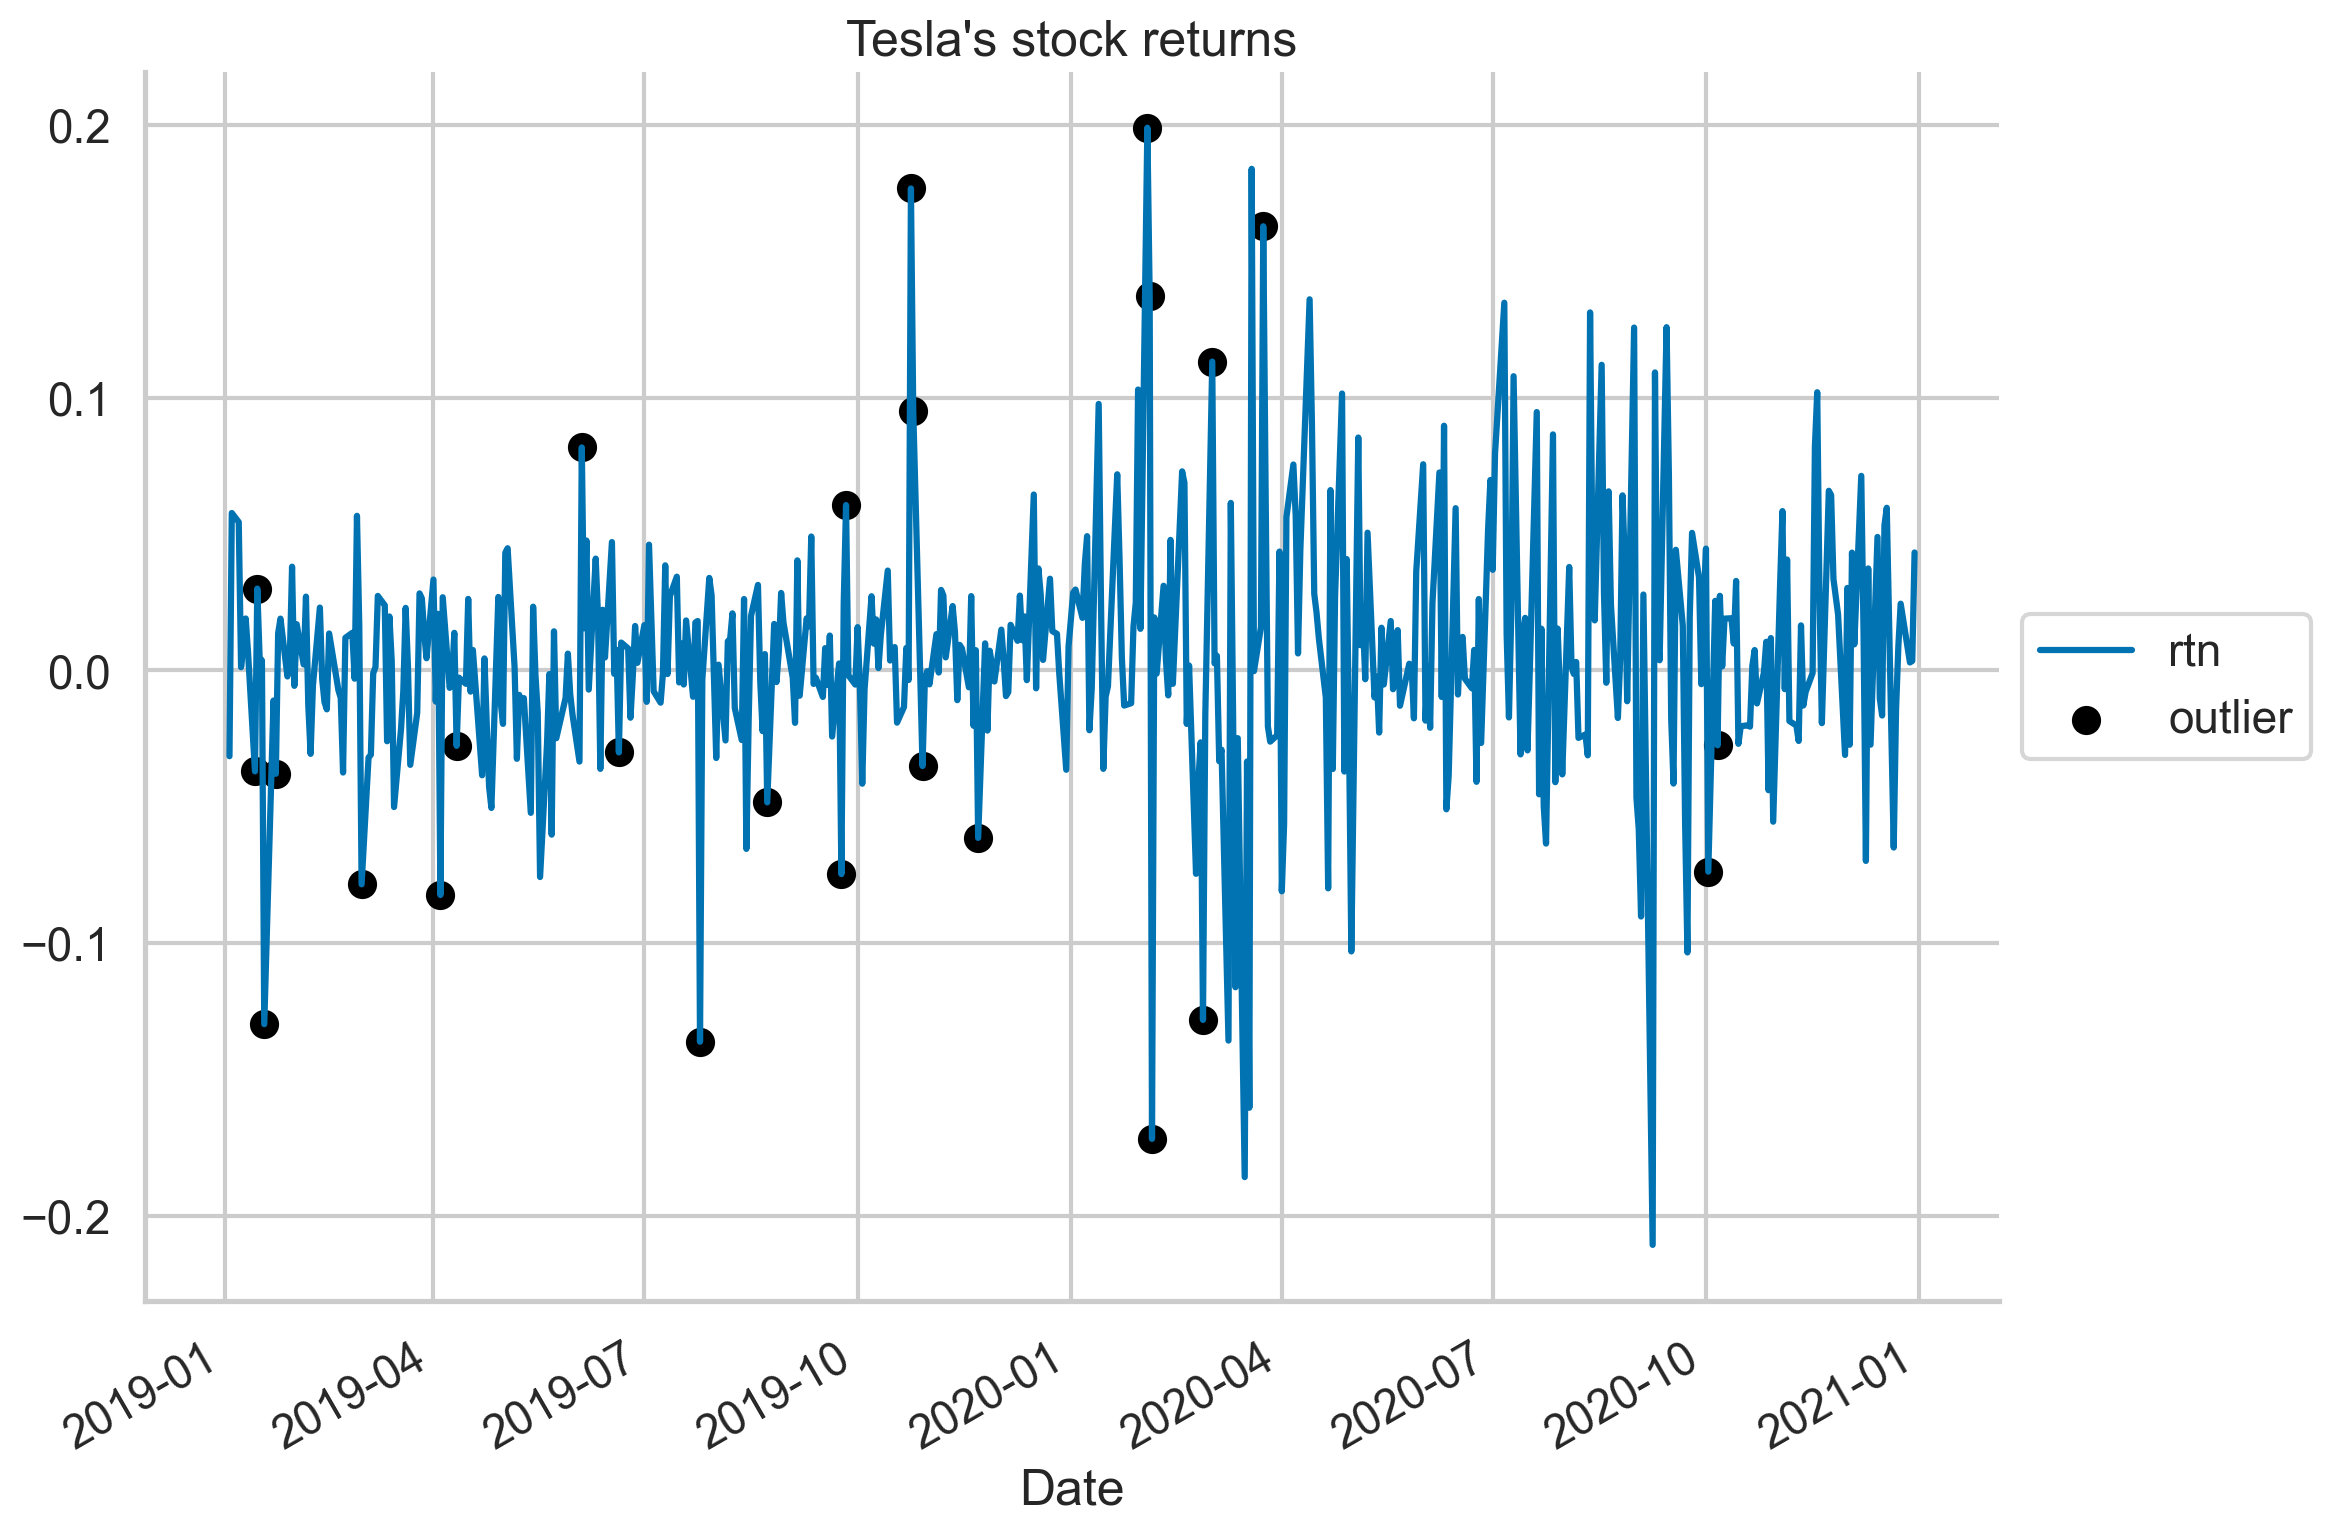

In [36]:
fig, ax = plt.subplots()

df[["rtn"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier_rtn"]].index, 
           df.loc[df["outlier_rtn"], "rtn"], 
           color="black", label="outlier")
ax.set_title("Tesla's stock returns")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_3", dpi=200)

3. Investigate the overlap in outliers identified for the prices and returns:

In [37]:
df.query("outlier == True and outlier_rtn == True").round(2)

,Open,High,Low,Close,Adj Close,Volume,rtn,outlier,outlier_rtn
Date,,,,,,,,,
2019-09-24,16.1,16.13,14.84,14.88,14.88,193372500,-0.07,True,True


## 4.5 Detecting patterns in a time series using the Hurst exponent

### How to do it...

1. Import the libraries:

In [38]:
import yfinance as yf
import numpy as np
import pandas as pd

2. Download S&P 500's historical prices from the years 2000-2019:

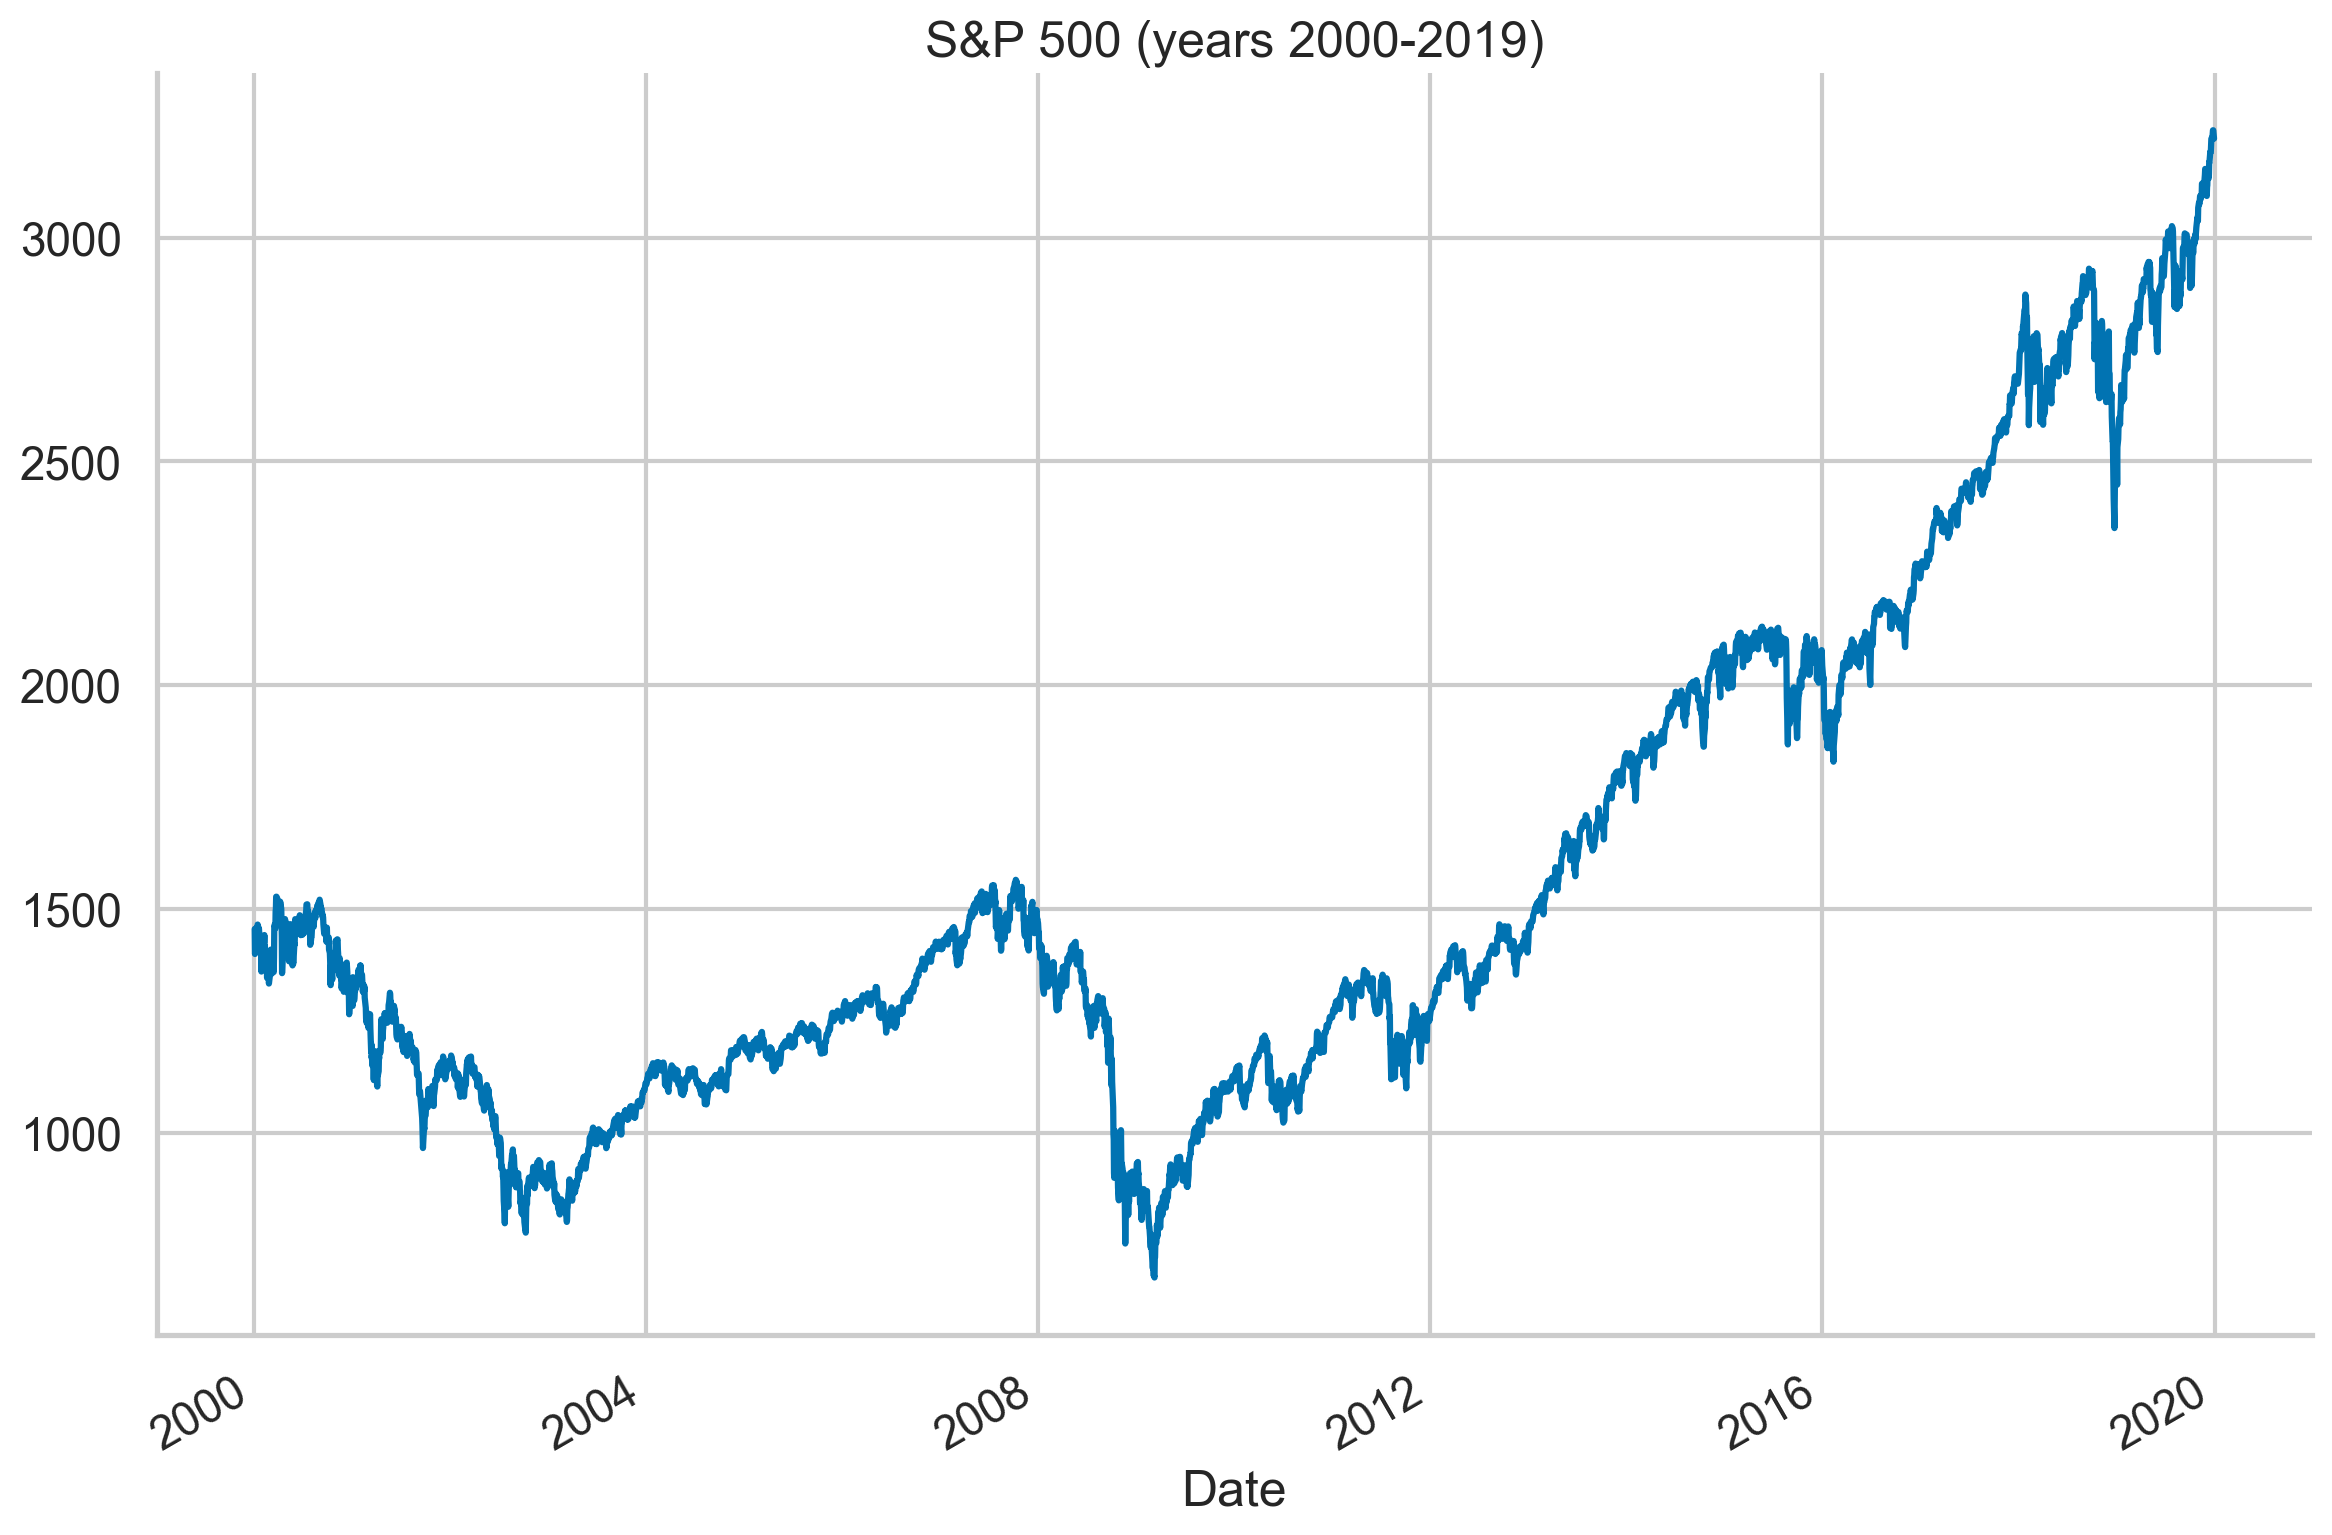

In [39]:
df = yf.download("^GSPC", 
                 start="2000-01-01", 
                 end="2019-12-31", 
                 progress=False)
df["Adj Close"].plot(title="S&P 500 (years 2000-2019)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_9", dpi=200);

3. Define a function calculating the Hurst exponent:

In [40]:
def get_hurst_exponent(ts, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # standard deviations of the lagged differences
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    hurst_exp = np.polyfit(np.log(lags), np.log(tau), 1)[0]

    return hurst_exp

4. Calculate the values of the Hurst exponent using different values for the `max_lag` parameter:

In [41]:
for lag in [20, 100, 250, 500, 1000]:
    hurst_exp = get_hurst_exponent(df["Adj Close"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.4481
Hurst exponent with 100 lags: 0.4513
Hurst exponent with 250 lags: 0.4918
Hurst exponent with 500 lags: 0.5265
Hurst exponent with 1000 lags: 0.5178


5. Narrow down the data to the years 2005-2007 and calculate the exponents one more time:

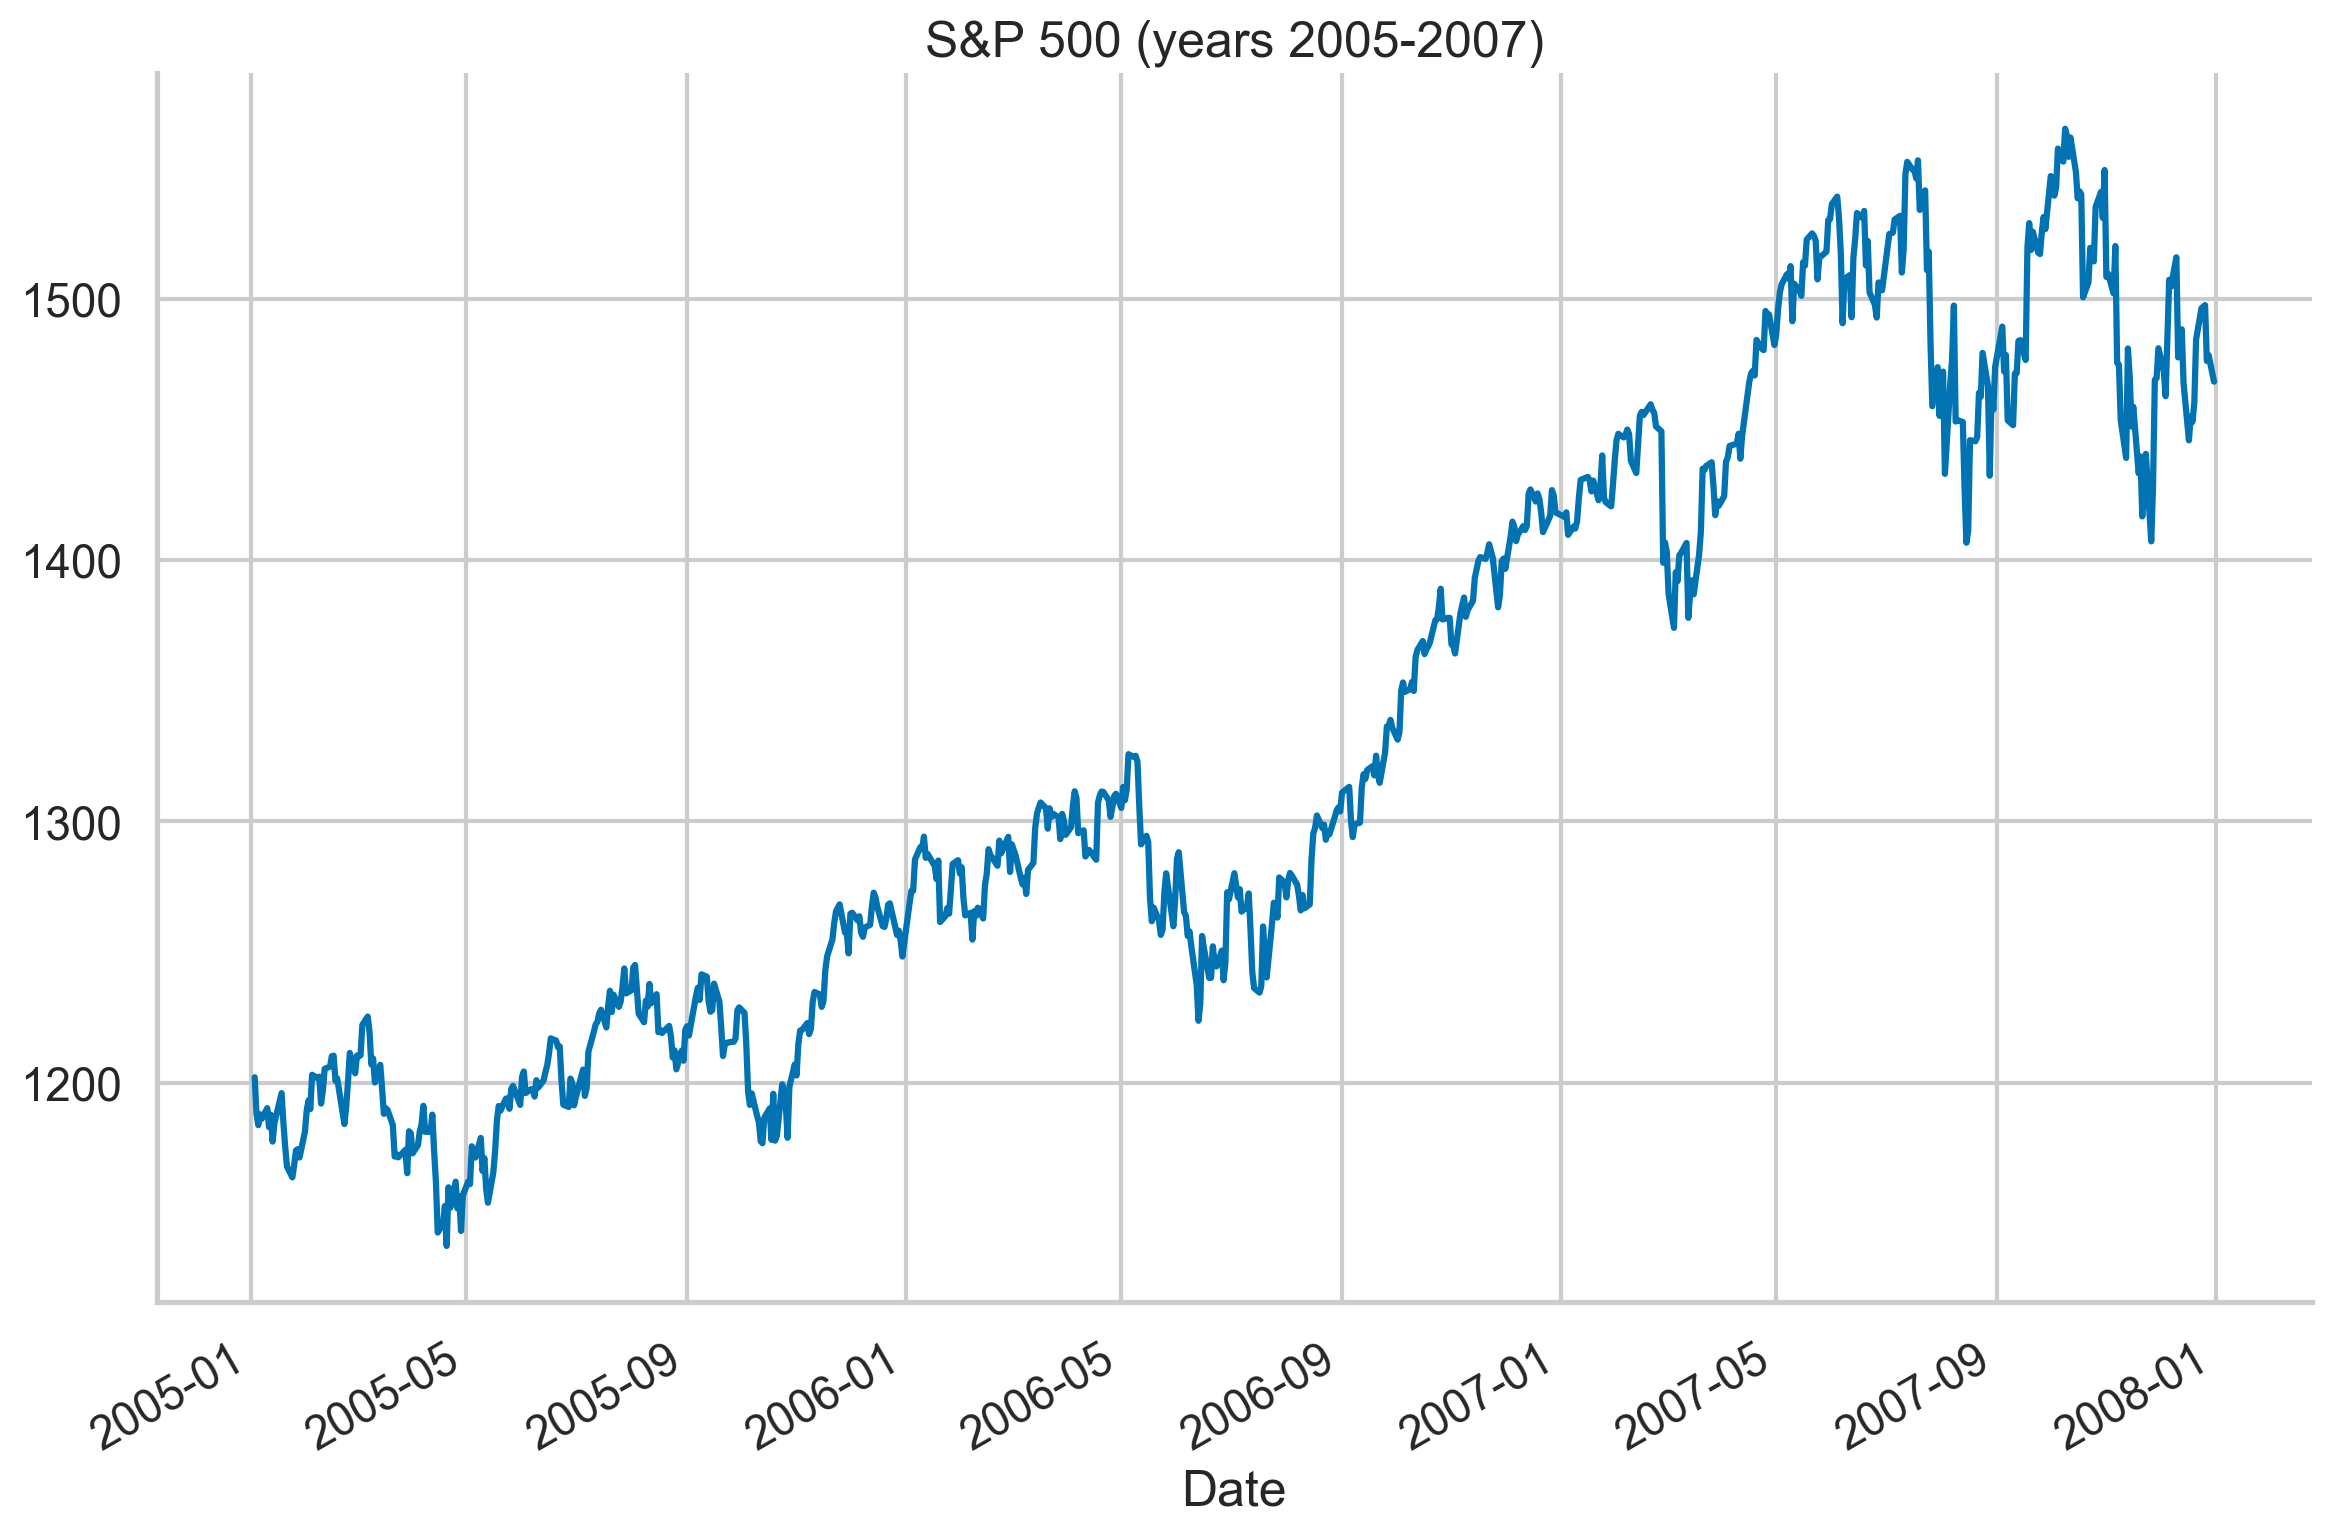

In [42]:
df.loc["2005":"2007", "Adj Close"].plot(title="S&P 500 (years 2005-2007)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_10", dpi=200);

In [43]:
shorter_series = df.loc["2005":"2007", "Adj Close"].values
for lag in [20, 100, 250, 500]:
    hurst_exp = get_hurst_exponent(shorter_series, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.3989
Hurst exponent with 100 lags: 0.3215
Hurst exponent with 250 lags: 0.2507
Hurst exponent with 500 lags: 0.1258


## 4.6 Investigating stylized facts of asset returns

### How to do it...

1. Import the libraries:

In [44]:
import pandas as pd 
import numpy as np
import yfinance as yf
import seaborn as sns 
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

2. Download the S&P 500 data and calculate the returns:

In [45]:
df = yf.download("^GSPC", 
                 start="2000-01-01", 
                 end="2020-12-31",
                 progress=False)

df = df[["Adj Close"]].rename(
    columns={"Adj Close": "adj_close"}
)
df["log_rtn"] = np.log(df["adj_close"]/df["adj_close"].shift(1))
df = df[["adj_close", "log_rtn"]].dropna()
df

,adj_close,log_rtn
Date,,
2000-01-04,1399.420044,-0.039099
2000-01-05,1402.109985,0.001920
2000-01-06,1403.449951,0.000955
2000-01-07,1441.469971,0.026730
2000-01-10,1457.599976,0.011128
...,...,...
2020-12-23,3690.010010,0.000746
2020-12-24,3703.060059,0.003530
2020-12-28,3735.360107,0.008685


#### Fact 1 - Non-Gaussian distribution of returns

1. Calculate the Normal PDF using the mean and standard deviation of the observed returns:

In [46]:
r_range = np.linspace(min(df["log_rtn"]), 
                      max(df["log_rtn"]), 
                      num=1000)
mu = df["log_rtn"].mean()
sigma = df["log_rtn"].std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)   

2. Plot the histogram and the Q-Q Plot:

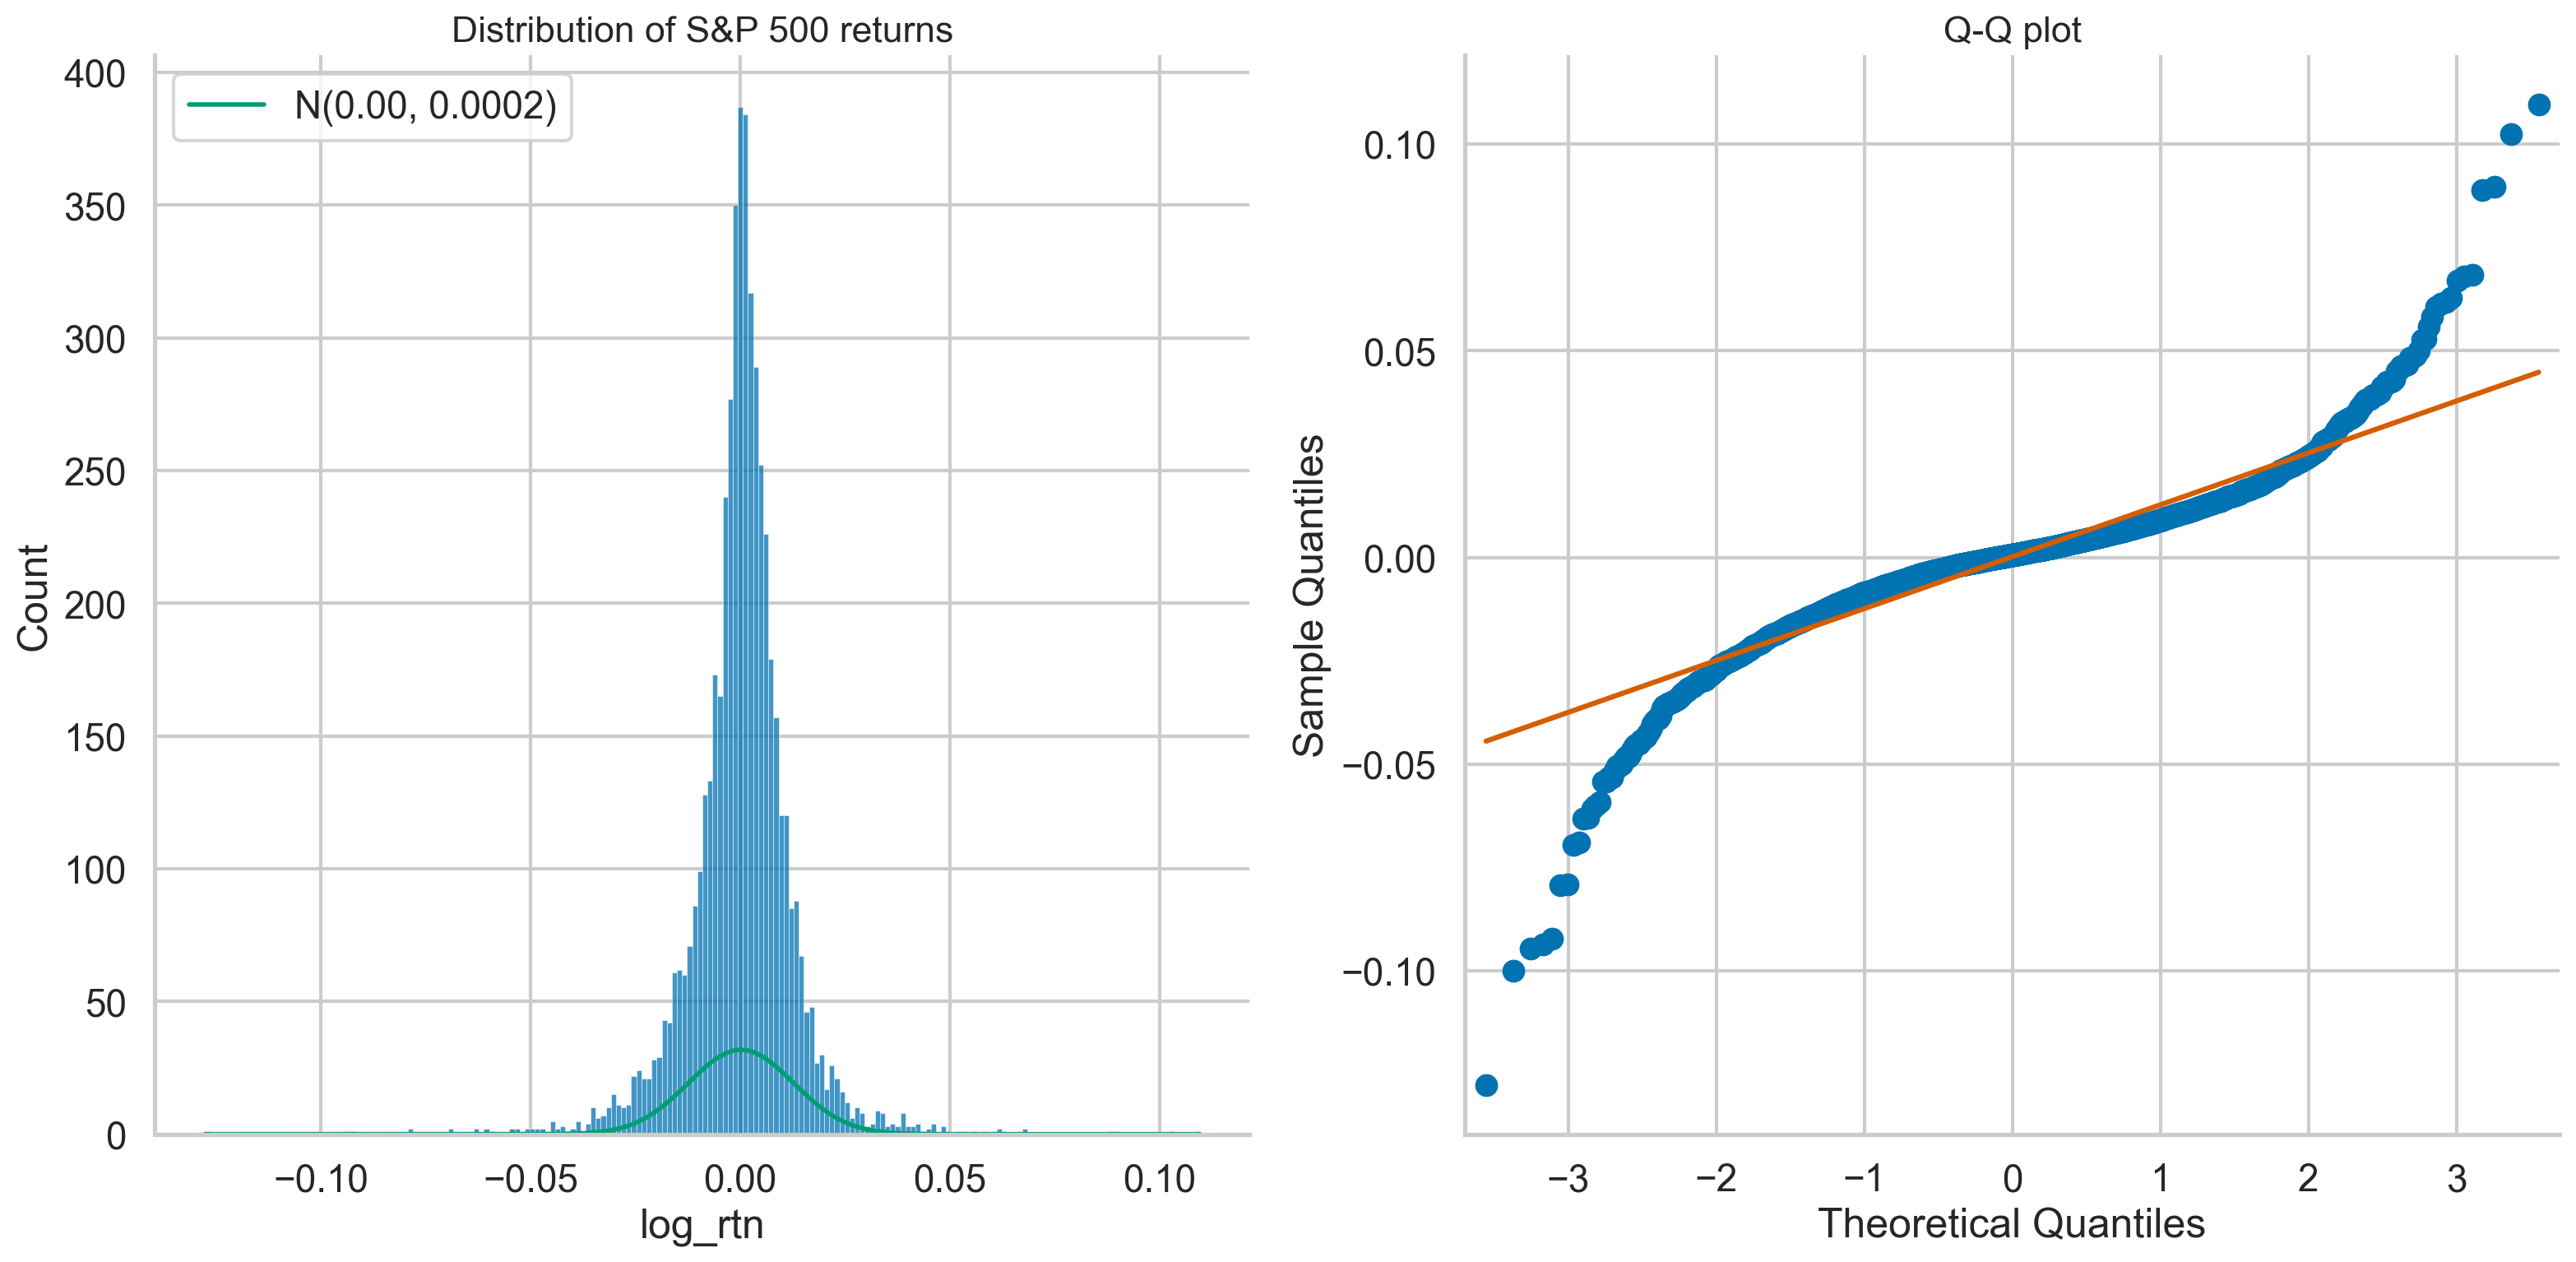

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.histplot(df.log_rtn, kde=False,  ax=ax[0])                                    
ax[0].set_title("Distribution of S&P 500 returns", 
                fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, "g", lw=2, 
           label=f"N({mu:.2f}, {sigma**2:.4f})")
ax[0].legend(loc="upper left");

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line="s", ax=ax[1])
ax[1].set_title("Q-Q plot", fontsize = 16)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_11", dpi=200);

3. Print the summary statistics of the log returns:

In [48]:
jb_test = scs.jarque_bera(df["log_rtn"].values)

print("---------- Descriptive Statistics ----------")
print("Range of dates:", min(df.index.date), "-", max(df.index.date))
print("Number of observations:", df.shape[0])
print(f"Mean: {df.log_rtn.mean():.4f}")
print(f"Median: {df.log_rtn.median():.4f}")
print(f"Min: {df.log_rtn.min():.4f}")
print(f"Max: {df.log_rtn.max():.4f}")
print(f"Standard Deviation: {df.log_rtn.std():.4f}")
print(f"Skewness: {df.log_rtn.skew():.4f}")
print(f"Kurtosis: {df.log_rtn.kurtosis():.4f}") 
print(f"Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}")

---------- Descriptive Statistics ----------
Range of dates: 2000-01-04 - 2020-12-30
Number of observations: 5282
Mean: 0.0002
Median: 0.0006
Min: -0.1277
Max: 0.1096
Standard Deviation: 0.0126
Skewness: -0.3935
Kurtosis: 10.9538
Jarque-Bera statistic: 26487.80 with p-value: 0.00


#### Fact 2 - Volatility Clustering

1. Run the following code to visualize the log returns series:

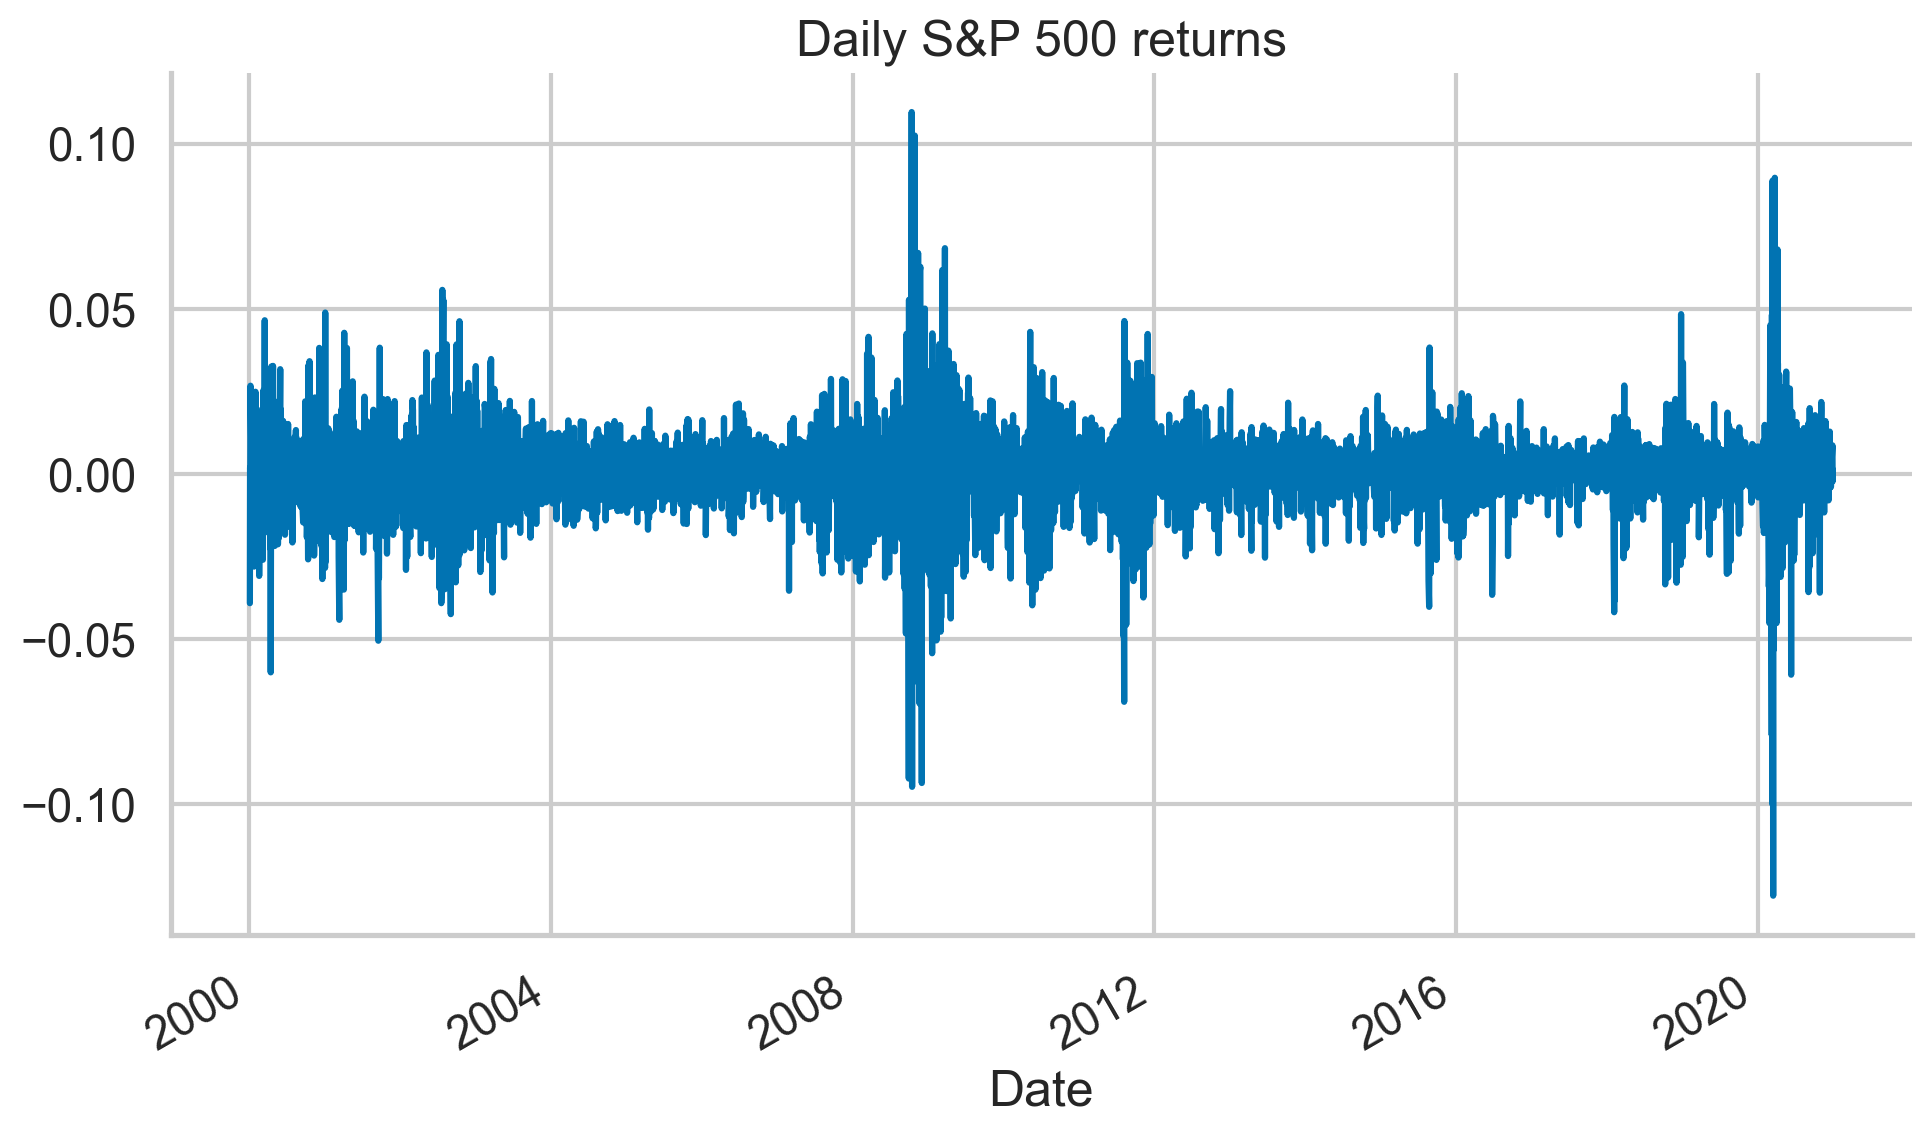

In [49]:
(
    df["log_rtn"]
    .plot(title="Daily S&P 500 returns", figsize=(10, 6))
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_12", dpi=200);

#### Fact 3 - Absence of autocorrelation in returns

1. Define the parameters for creating the autocorrelation plots:

In [50]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

2. Run the following code to create ACF plot of log returns:

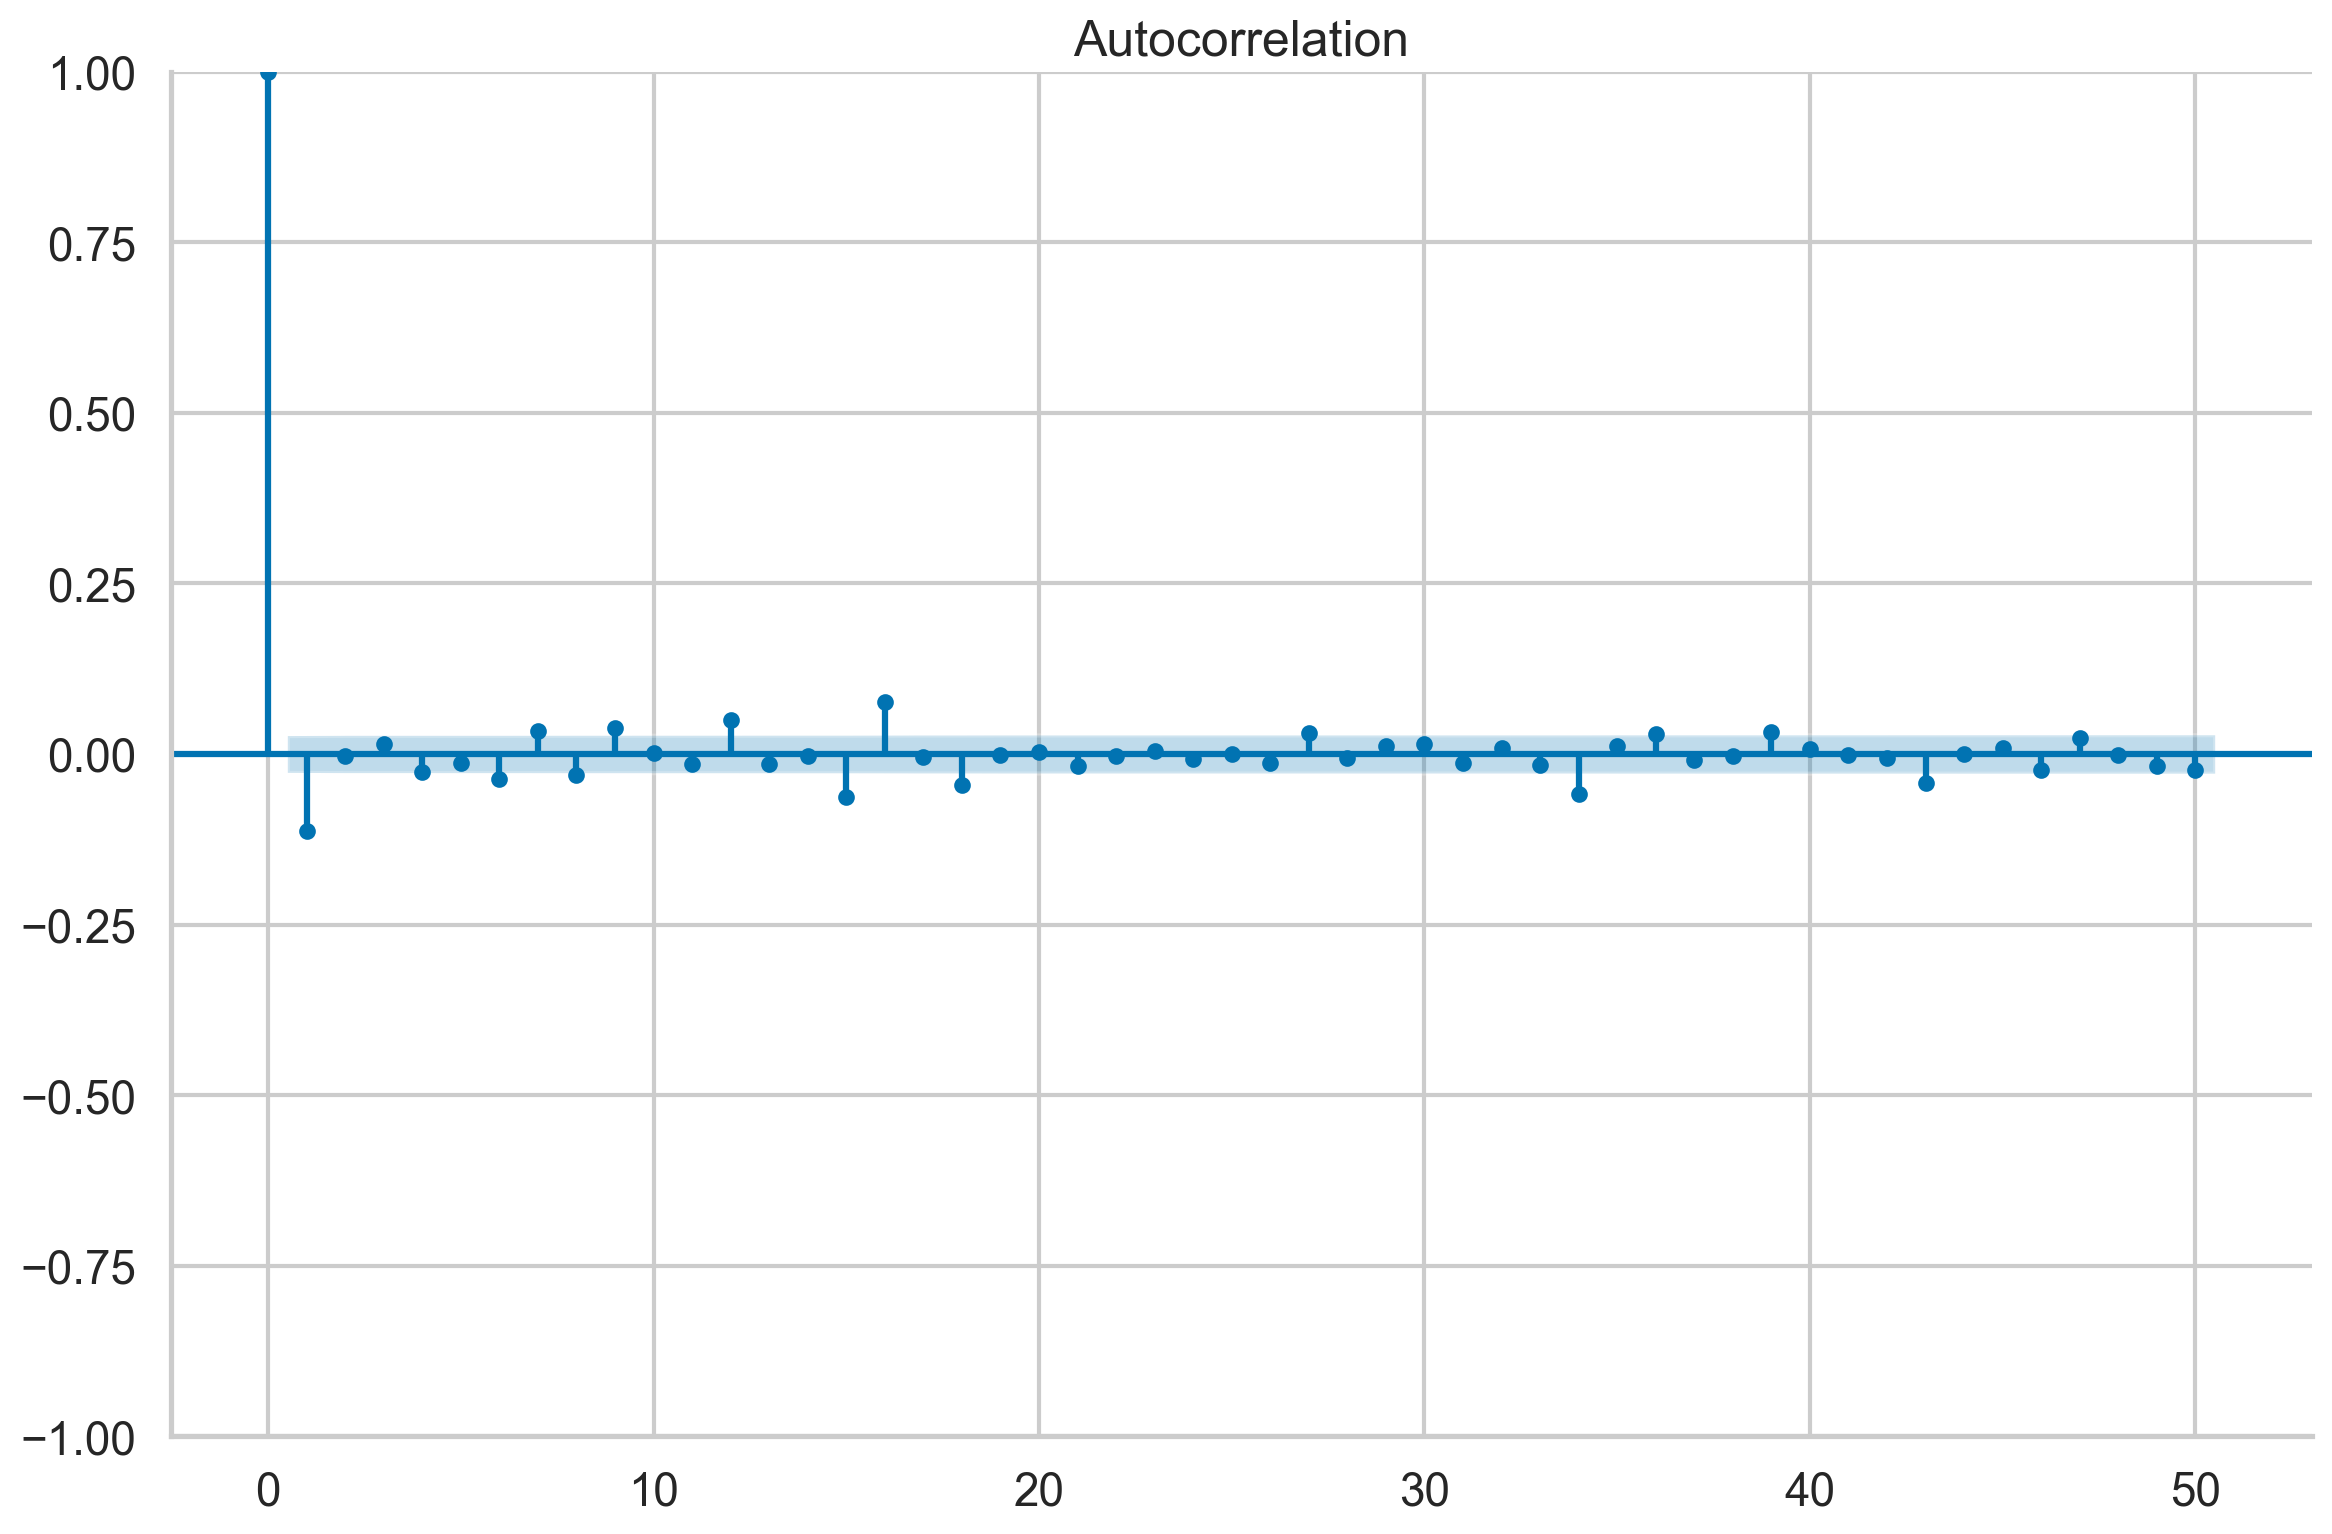

In [51]:
acf = smt.graphics.plot_acf(df["log_rtn"], 
                            lags=N_LAGS, 
                            alpha=SIGNIFICANCE_LEVEL)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_13", dpi=200);

#### Fact 4 - Small and decreasing autocorrelation in squared/absolute returns

1. Create the ACF plots:

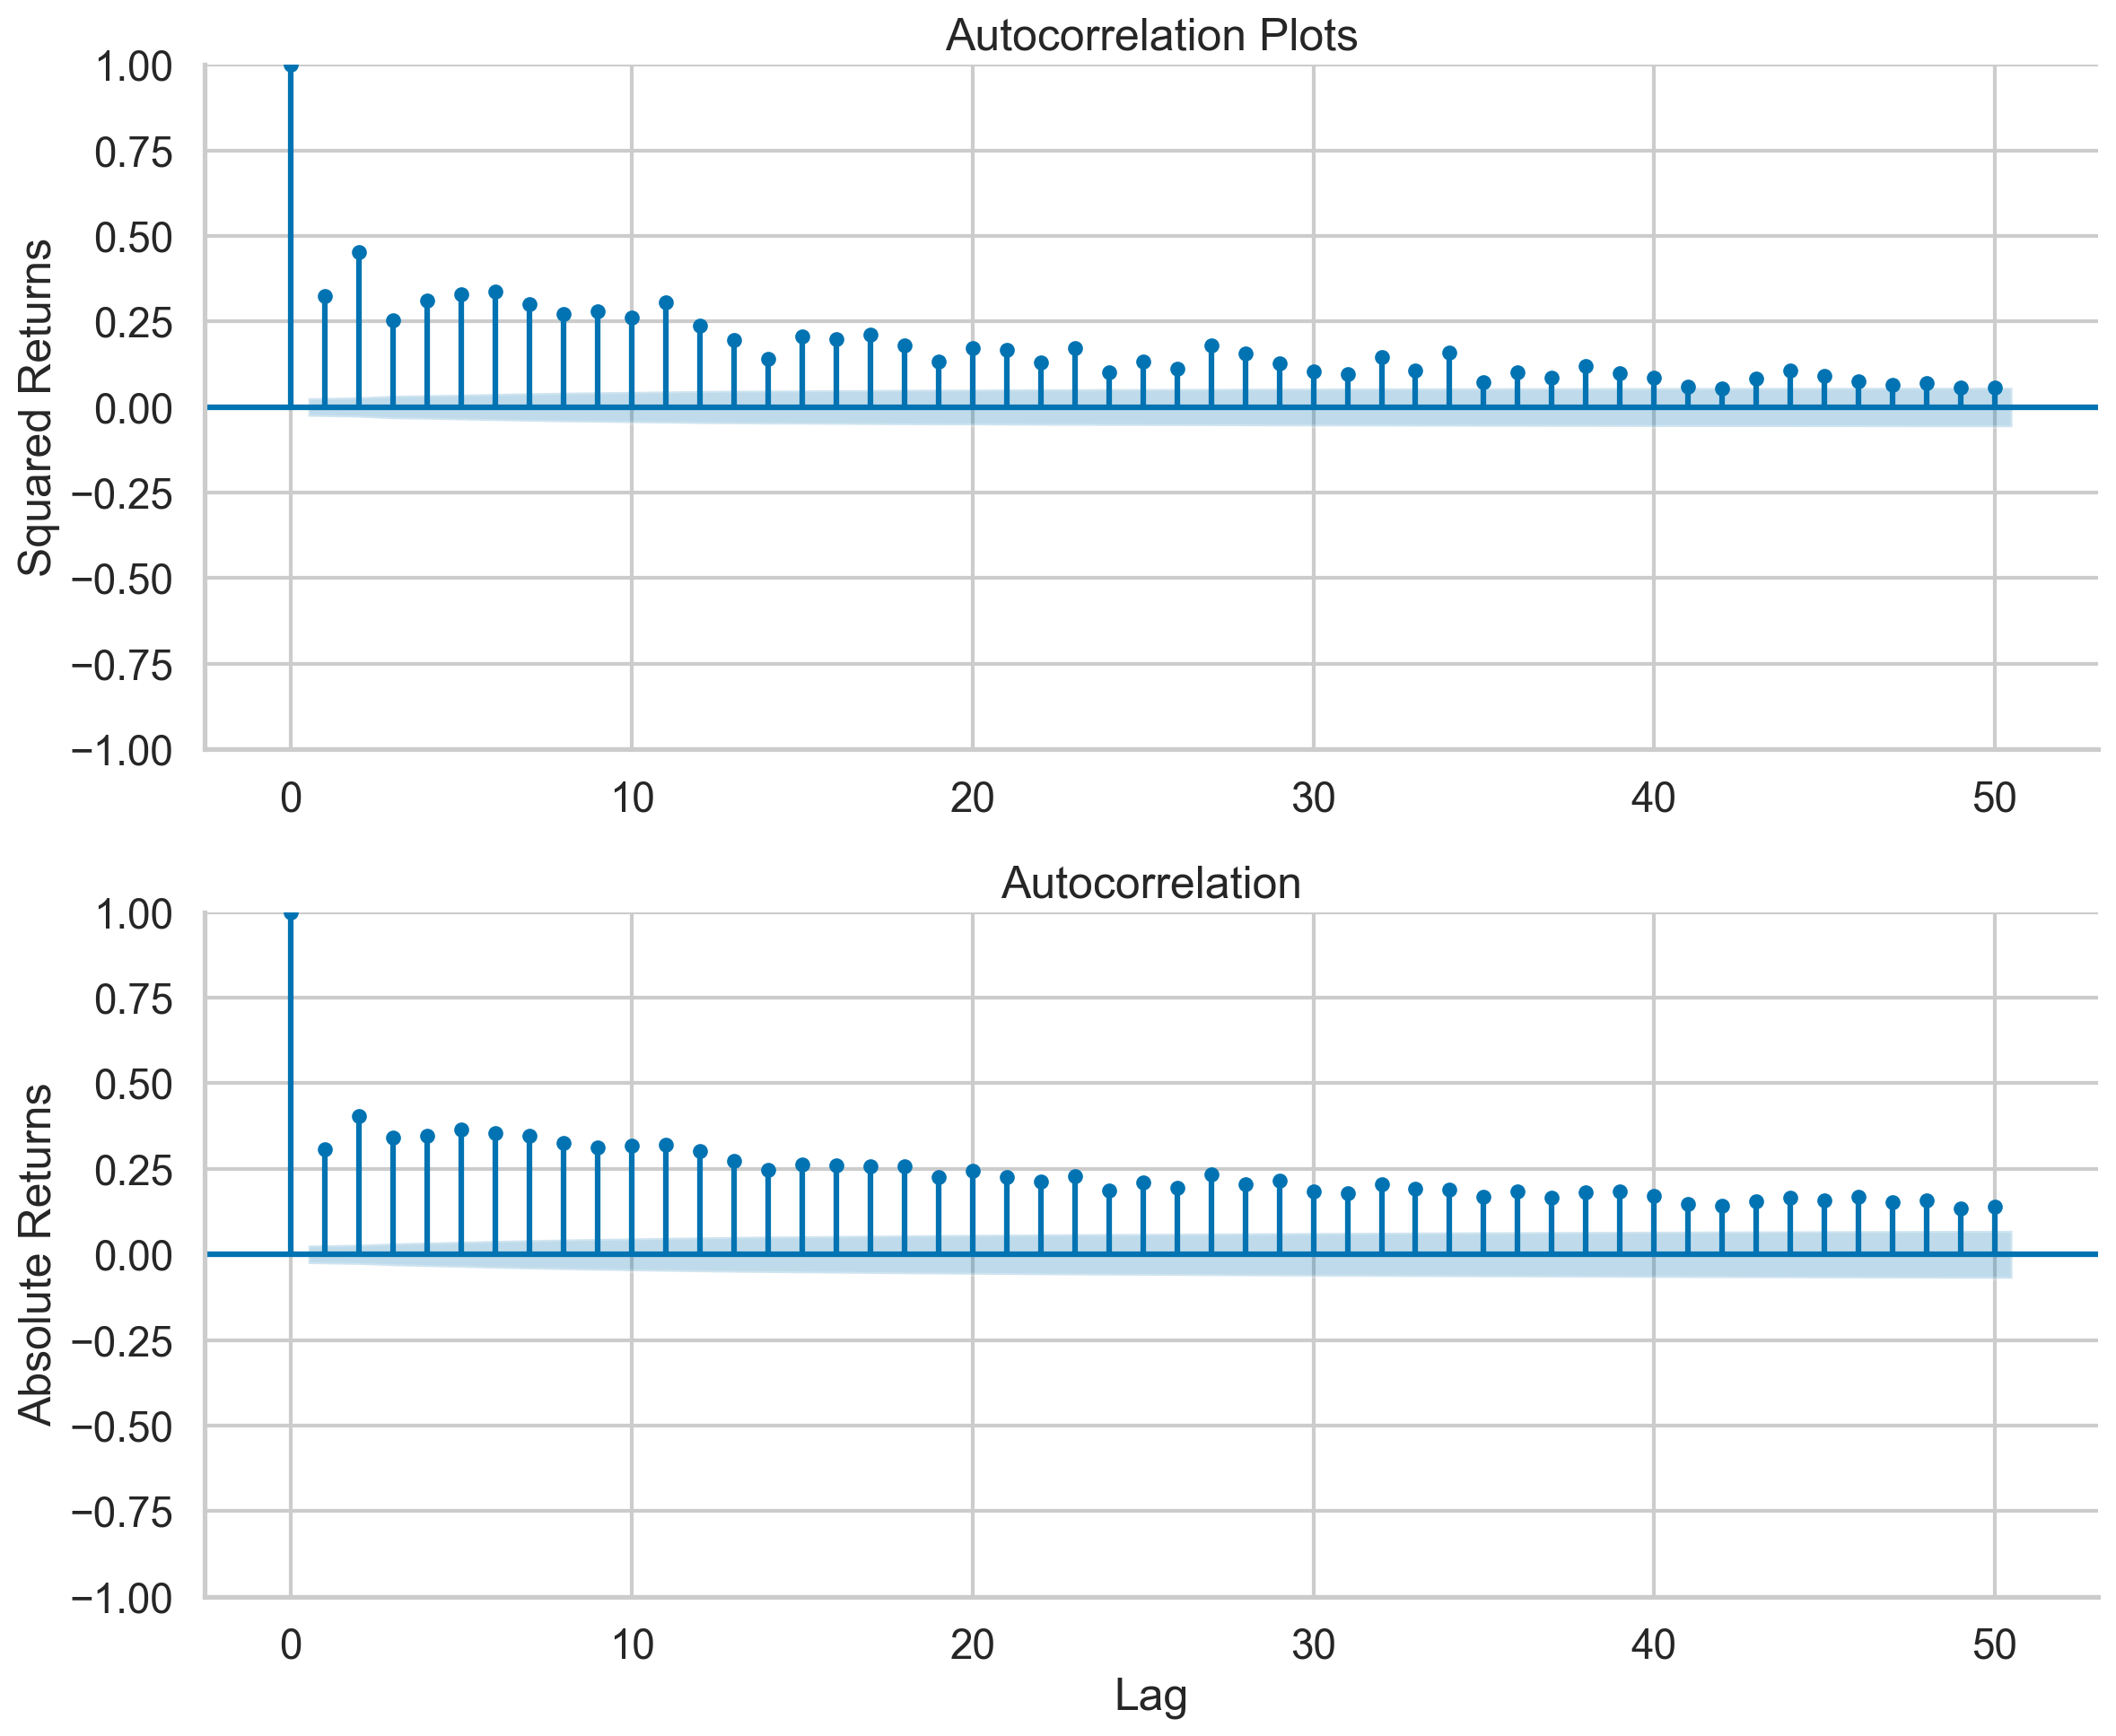

In [52]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

smt.graphics.plot_acf(df["log_rtn"]**2, lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title="Autocorrelation Plots",
          ylabel="Squared Returns")

smt.graphics.plot_acf(np.abs(df["log_rtn"]), lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel="Absolute Returns",
          xlabel="Lag")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_14", dpi=200);

#### Fact 5 - Leverage effect

1. Calculate volatility measures as moving standard deviations

In [53]:
df["rolling_std_252"] = df[["log_rtn"]].rolling(window=252).std()
df["rolling_std_21"] = df[["log_rtn"]].rolling(window=21).std()

2. Plot all the series:

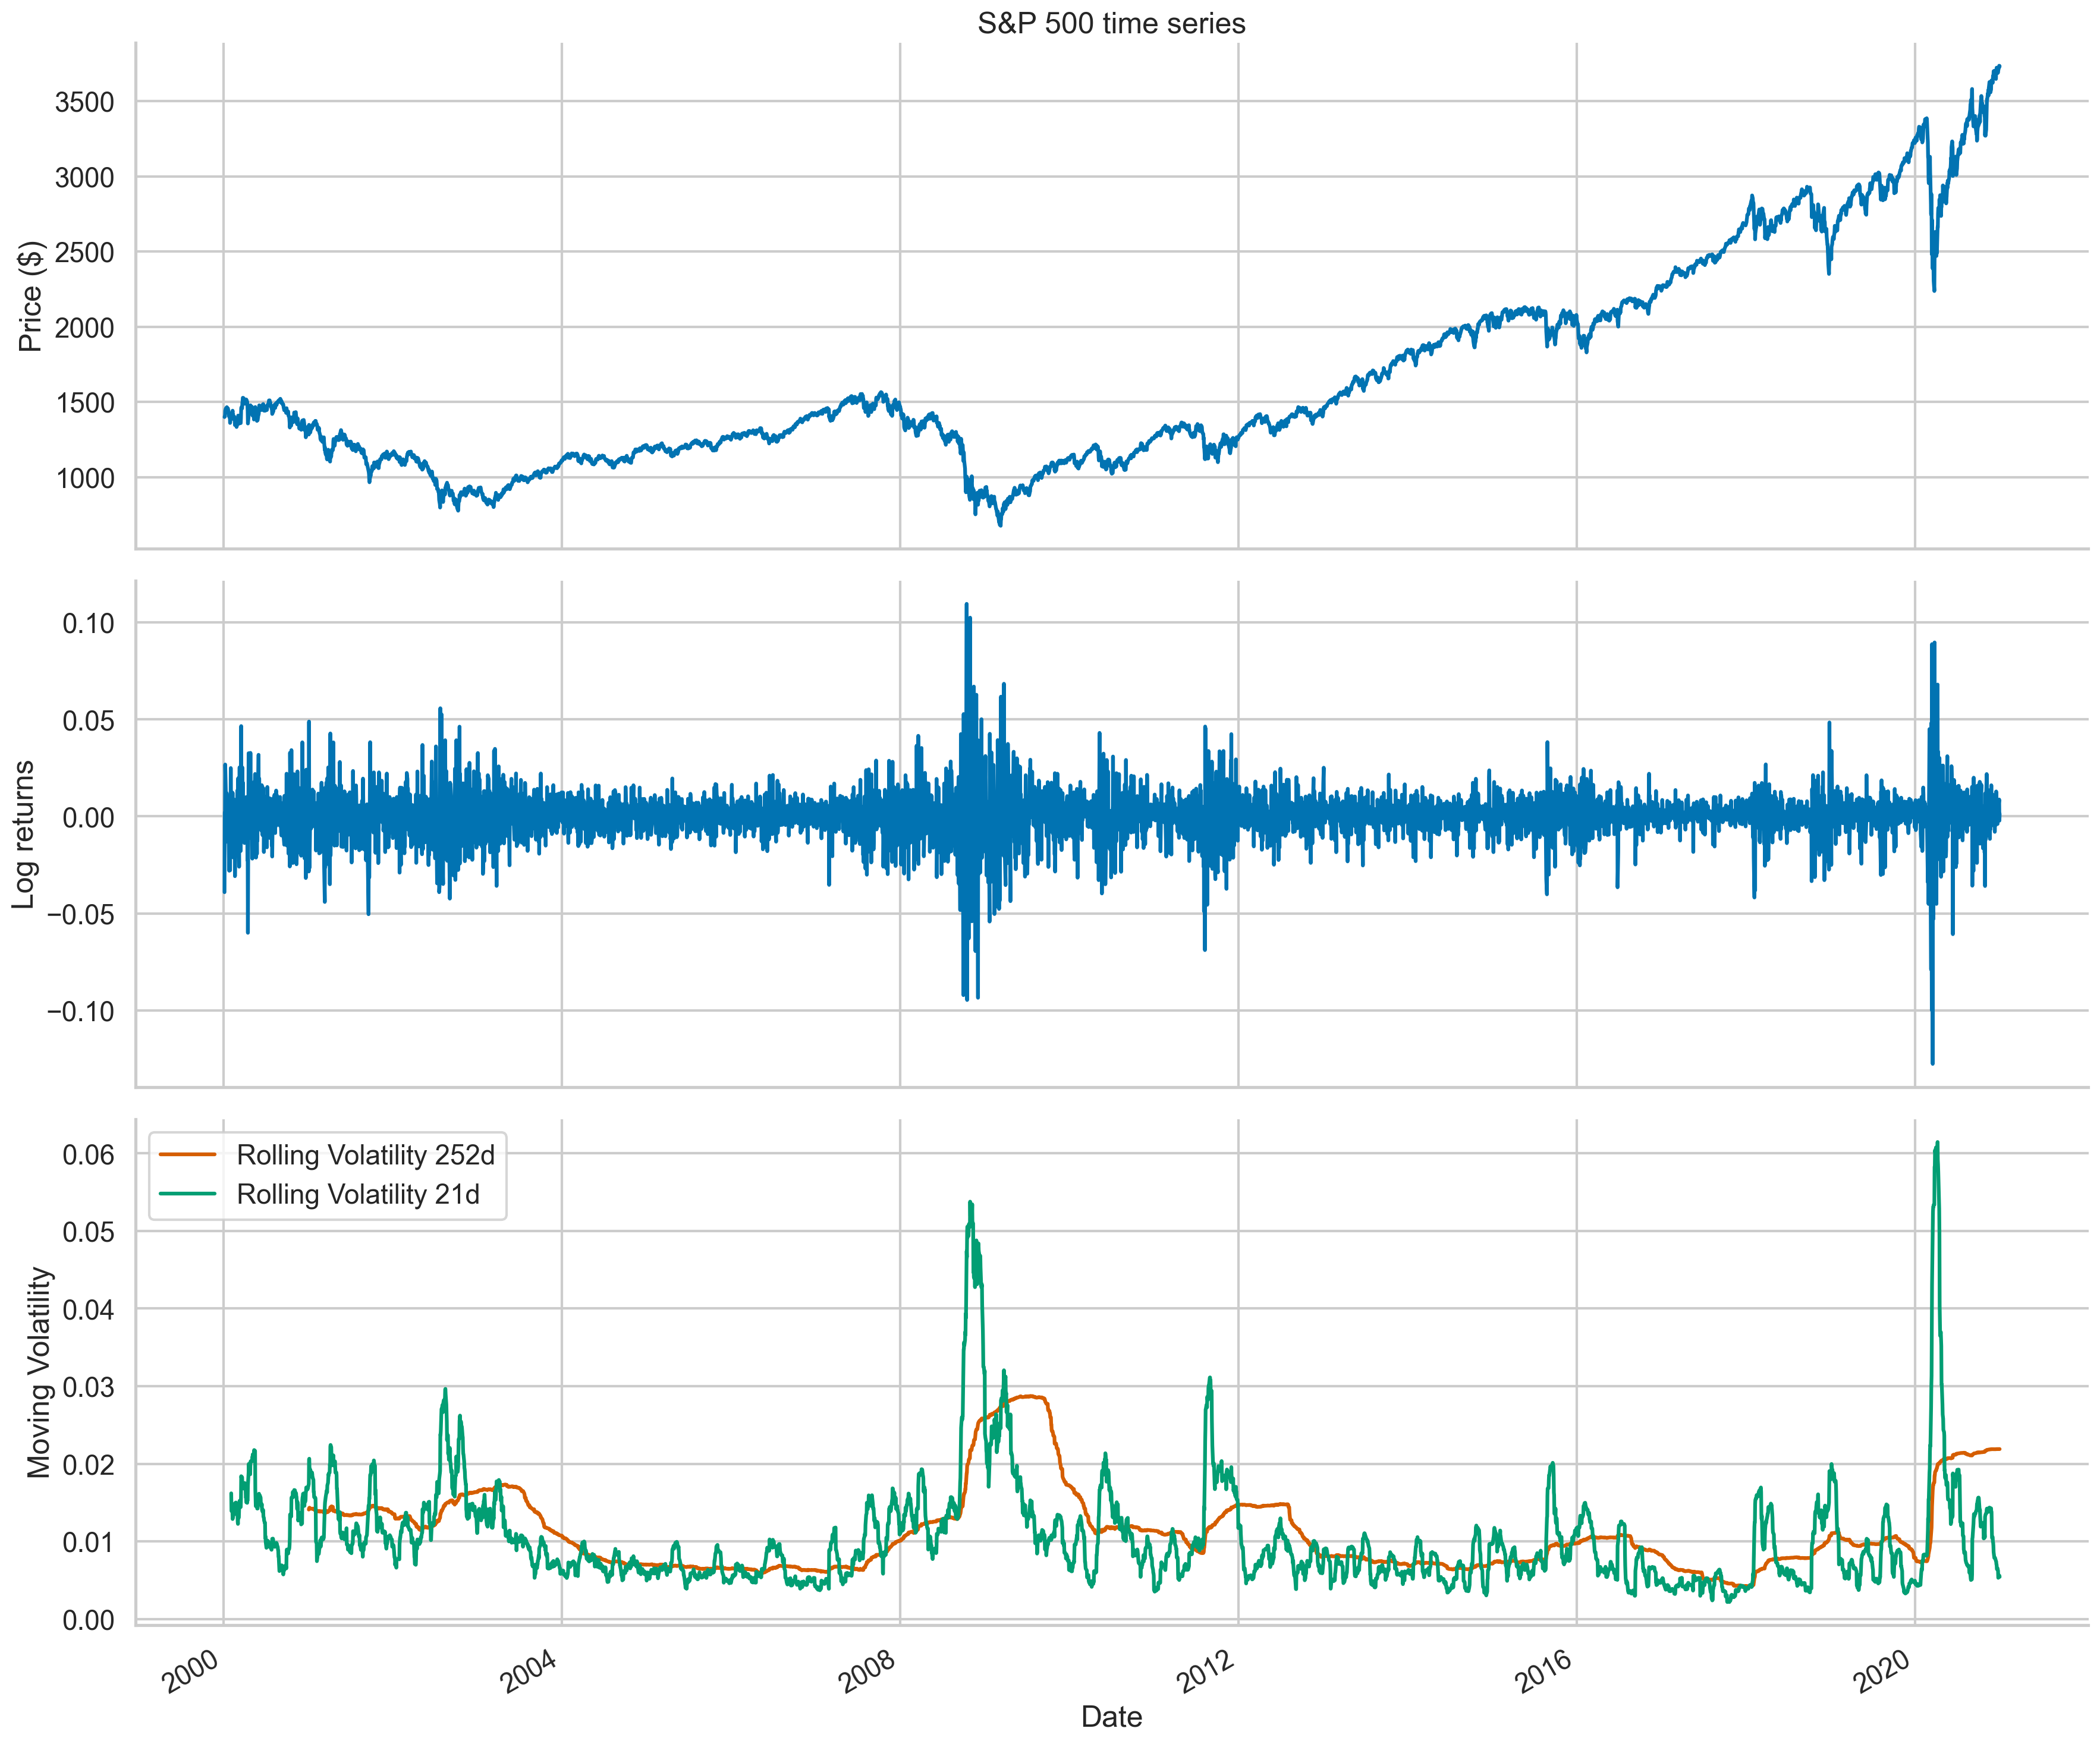

In [54]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15), 
                       sharex=True)

df["adj_close"].plot(ax=ax[0])
ax[0].set(title="S&P 500 time series",
          ylabel="Price ($)")

df["log_rtn"].plot(ax=ax[1])
ax[1].set(ylabel="Log returns")

df["rolling_std_252"].plot(ax=ax[2], color="r", 
                           label="Rolling Volatility 252d")
df["rolling_std_21"].plot(ax=ax[2], color="g", 
                           label="Rolling Volatility 21d")
ax[2].set(ylabel="Moving Volatility",
          xlabel="Date")
ax[2].legend()

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_15", dpi=200);

### There's more

1. Download and preprocess the prices of the S&P 500 and VIX:

In [55]:
df = yf.download(["^GSPC", "^VIX"], 
                 start="2000-01-01", 
                 end="2020-12-31",
                 progress=False)
df = df[["Adj Close"]]
df.columns = df.columns.droplevel(0)
df = df.rename(columns={"^GSPC": "sp500", "^VIX": "vix"})

2. Calculate the log returns (we can just as well use percentage change-simple returns):

In [56]:
df["log_rtn"] = np.log(df["sp500"] / df["sp500"].shift(1))
df["vol_rtn"] = np.log(df["vix"] / df["vix"].shift(1))
df.dropna(how="any", axis=0, inplace=True)

3. Plot a scatterplot with the returns on the axes and fit a regression line to identify the trend:

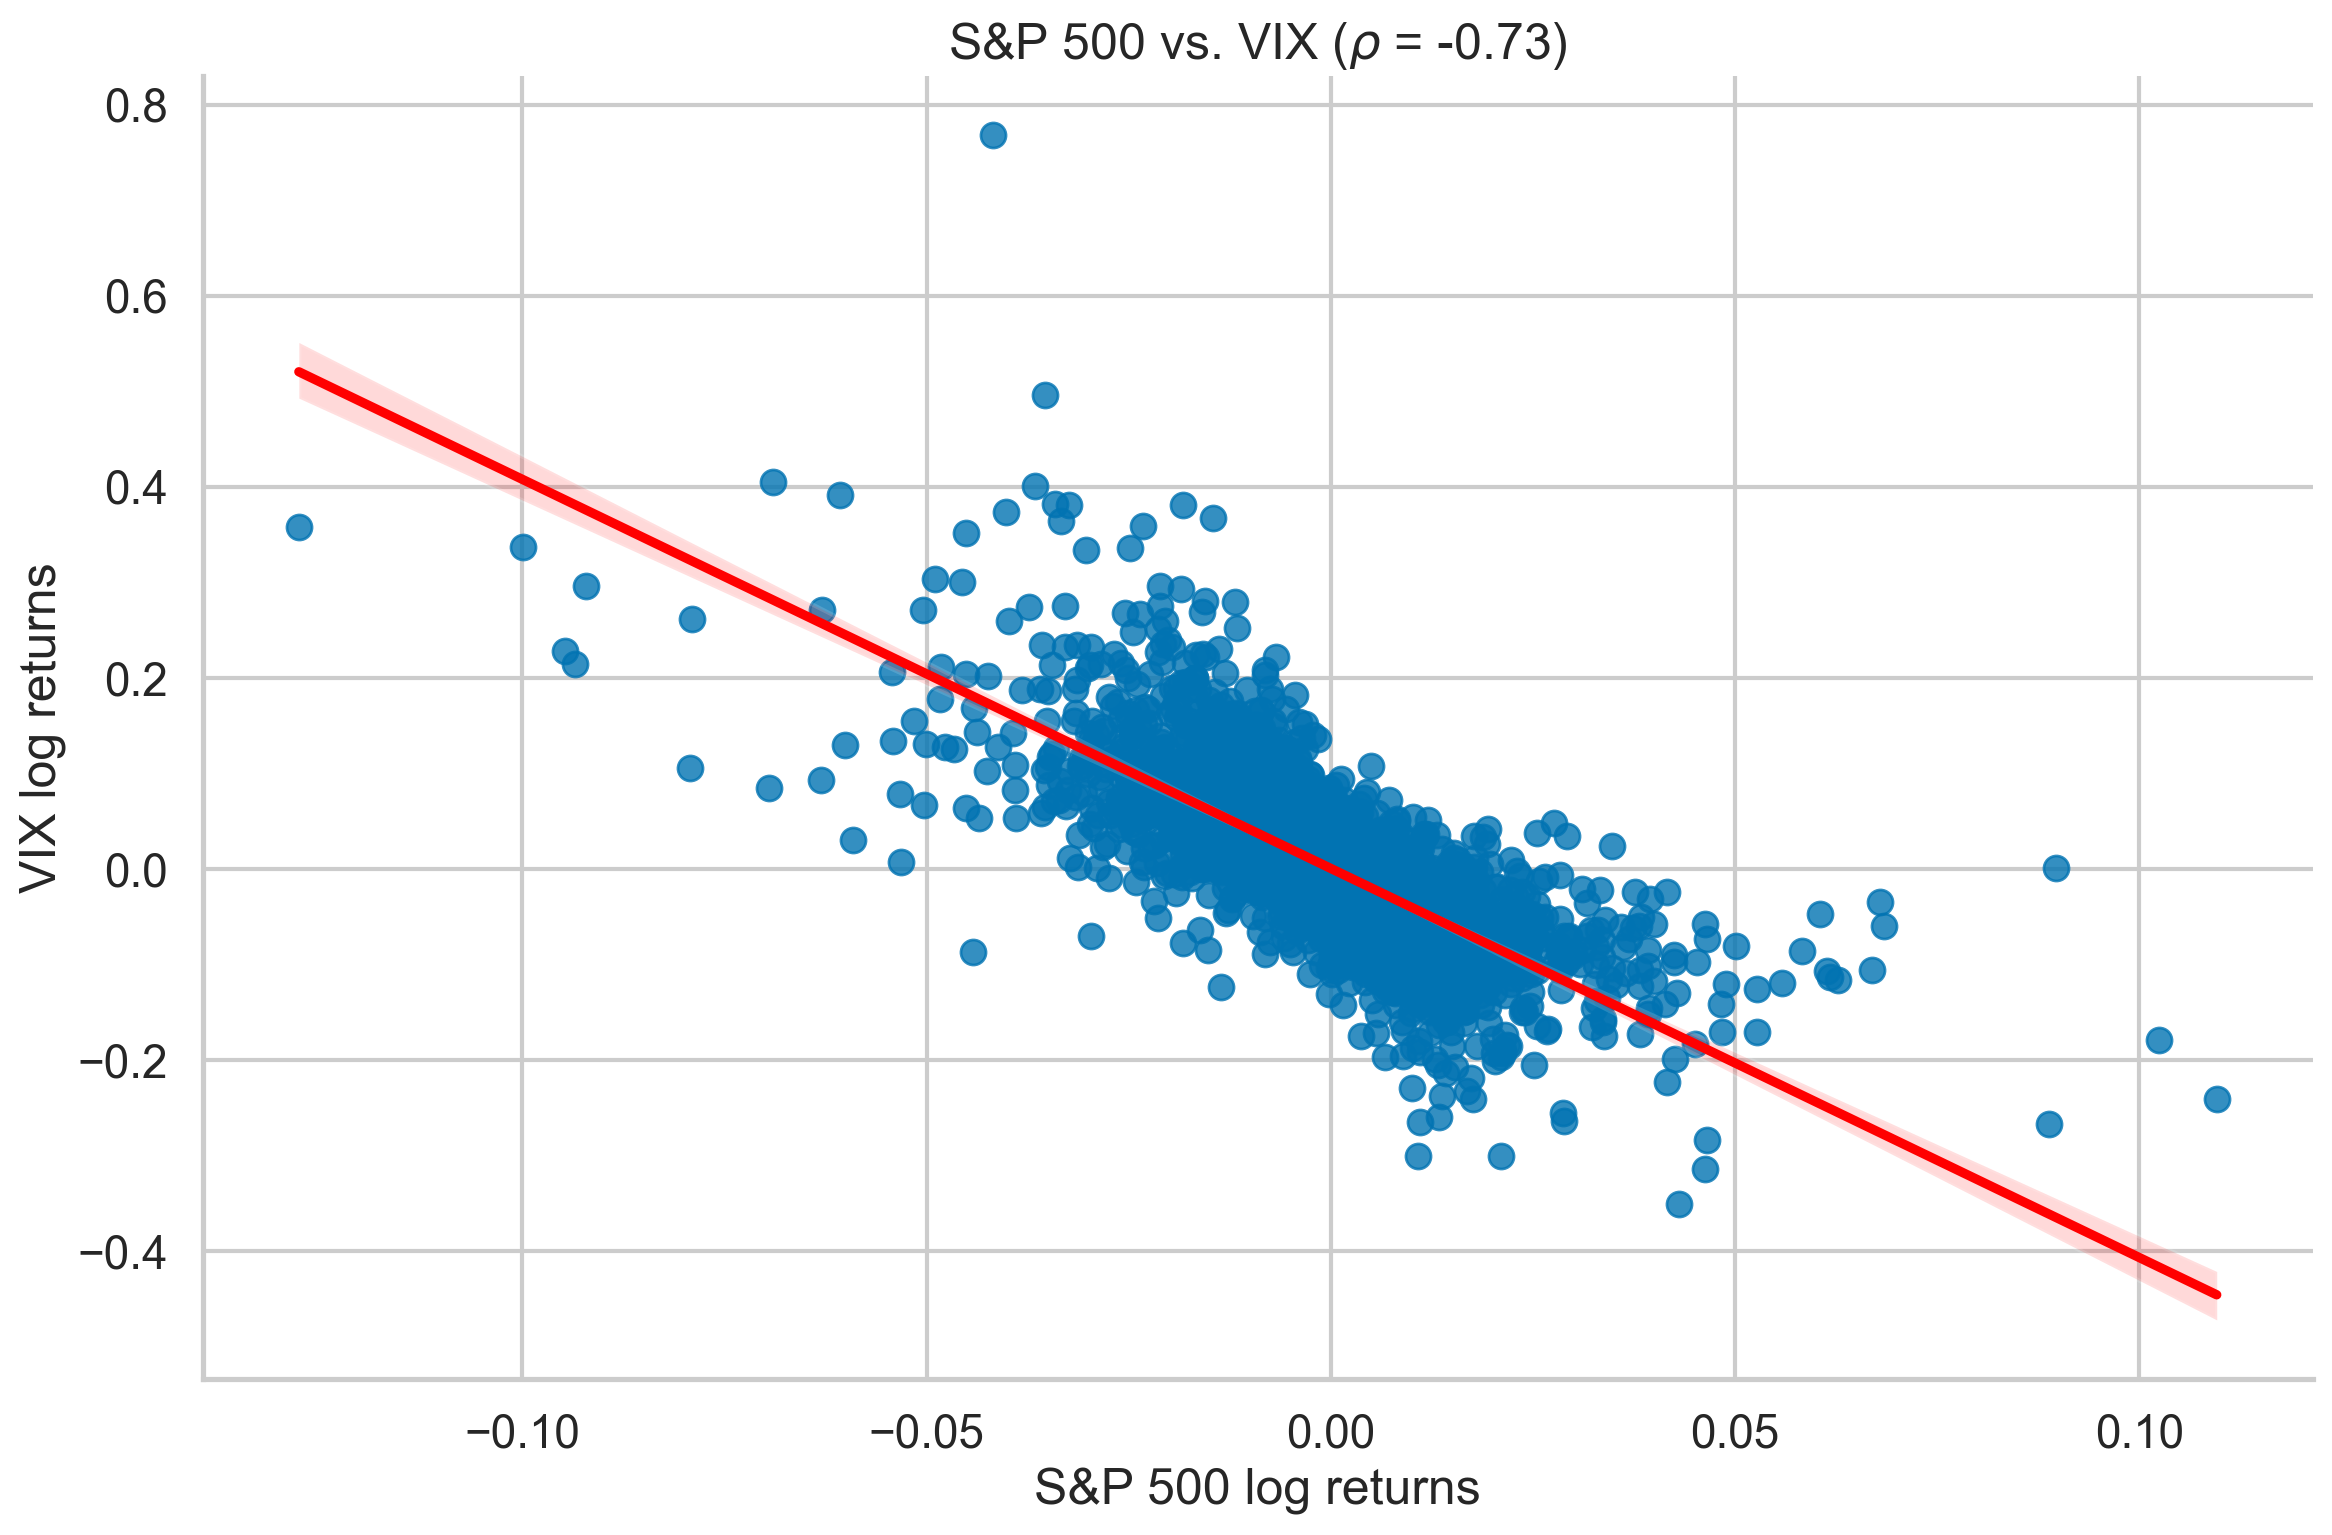

In [57]:
corr_coeff = df.log_rtn.corr(df.vol_rtn)

ax = sns.regplot(x="log_rtn", y="vol_rtn", data=df, 
                 line_kws={"color": "red"})
ax.set(title=f"S&P 500 vs. VIX ($\\rho$ = {corr_coeff:.2f})",
       ylabel="VIX log returns",
       xlabel="S&P 500 log returns")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_16", dpi=200);